In [11]:
import phoebe
from phoebe import u, c

import numpy as np

import matplotlib
import scienceplots
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16, 6)
plt.style.use('science')

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

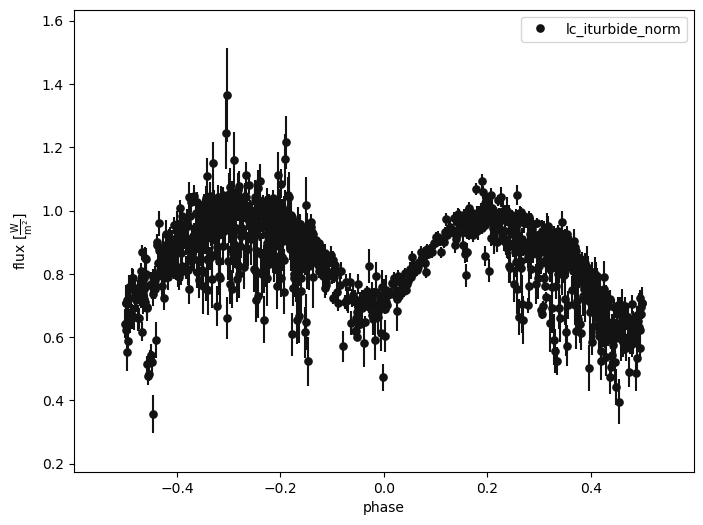

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [2]:
# b = phoebe.load("./bundle-saves/manual-periodogram")
# b = phoebe.load("./bundle-saves/aviles-data/manual-periodogram")
# b = phoebe.load("./bundle-saves/comp-LID3/manual-periodogram", import_from_newer=True)
# b = phoebe.load("../bundle-saves/iturbide-gaia-ztf")
b = phoebe.load("../bundle-saves/relative-normalized/iturbide-gaia-ztf")
# gen_utils.resetAtmosphere(b)

b.plot(x='phase', dataset='lc_iturbide_norm', show=True, legend=True, marker='.')
# b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

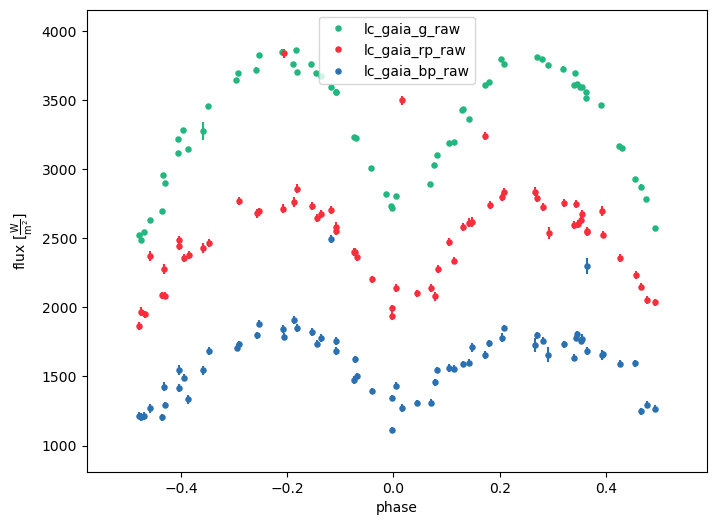

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [4]:
# normGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'norm' in d]
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]

# b.plot(x='phase', dataset=normGaiaDatasets, color=gen_utils.GAIA_NORM_PLOT_COLORS, show=True, legend=True, marker='.', s=0.015)
b.plot(x='phase', dataset=rawGaiaDatasets, color=gen_utils.GAIA_RAW_PLOT_COLORS, show=True, legend=True, marker='.', s=0.015)

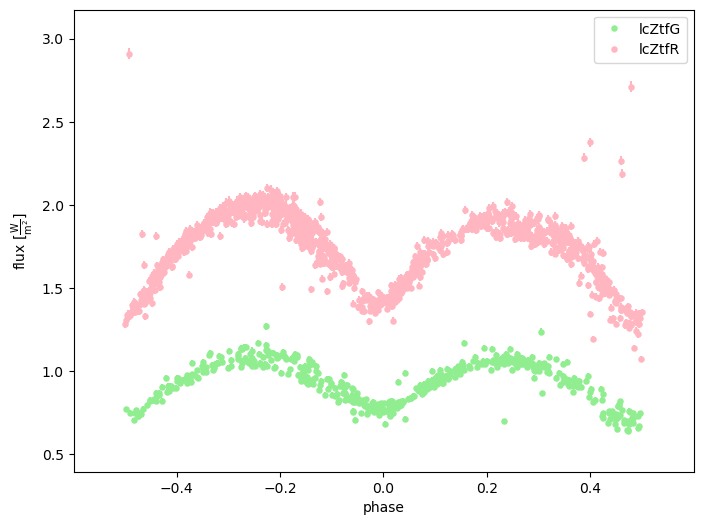

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [5]:
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

b.plot(x='phase', dataset=ztfDatasets, color=gen_utils.ZTF_PLOT_COLORS, show=True, legend=True, marker='.', s=0.015)

In [6]:
# plotRawDatasetsGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets, ztfDatasets]

def printChi2(b: phoebe.Bundle, model: str):
	print(f"{model} chi2", "===================================================", sep='\n')

	#region Iturbide
	try:
		print('\t', "Iturbide (Aviles) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	except: pass

	try:
		print('\t', "Iturbide (Full) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_full_raw')))
	except: pass
	#endregion

	#region Gaia
	try:
		print('\t', "Gaia (Raw)-", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass

	# try:
	# 	print('\t', "Gaia (Normalized)-", np.sum(b.calculate_chi2(model=model, dataset=normGaiaDatasets)))
	# except: pass

	# try:
	# 	for gd in normGaiaDatasets:
	# 		print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	# except: pass
	#endregion

	#region ZTF
	try:
		print('\t', "ZTF -", np.sum(b.calculate_chi2(model=model, dataset=ztfDatasets)))
	except: pass

	try:
		for zd in ztfDatasets:
			print('\t\t', zd, "-", np.sum(b.calculate_chi2(model=model, dataset=zd)))
	except: pass
	#endregion

def printAllModelsChi2(b: phoebe.Bundle):
	for m in b.models:
		printChi2(b, m)

### Default forward models

In [7]:
# EBAI KNN values all seem to affect relative values
    # setting to dataset-scaled to see if at least general shape of model is correct
    # might also help with getting a good trend out of residuals when adopting estimator solutions
b.set_value_all(qualifier='pblum_mode', value='dataset-scaled')

In [8]:
b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='default_model', overwrite=True)

100%|██████████| 3194/3194 [03:01<00:00, 17.58it/s]


<ParameterSet: 181 parameters | kinds: mesh, lc>

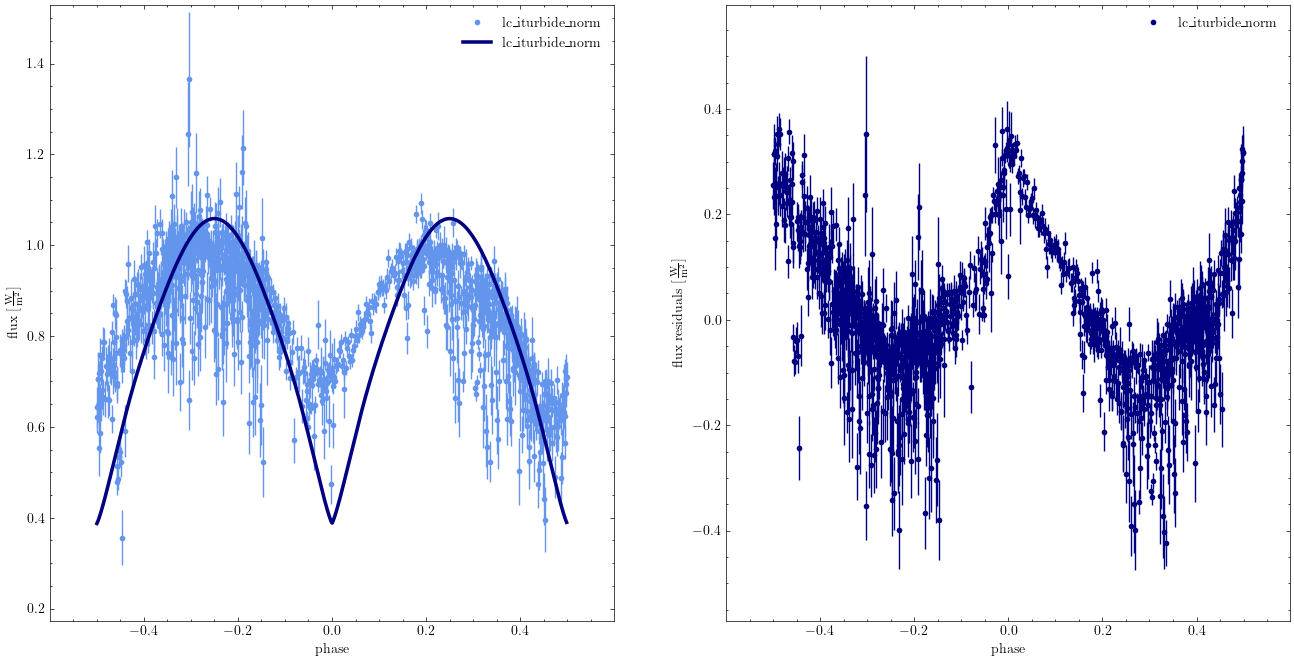

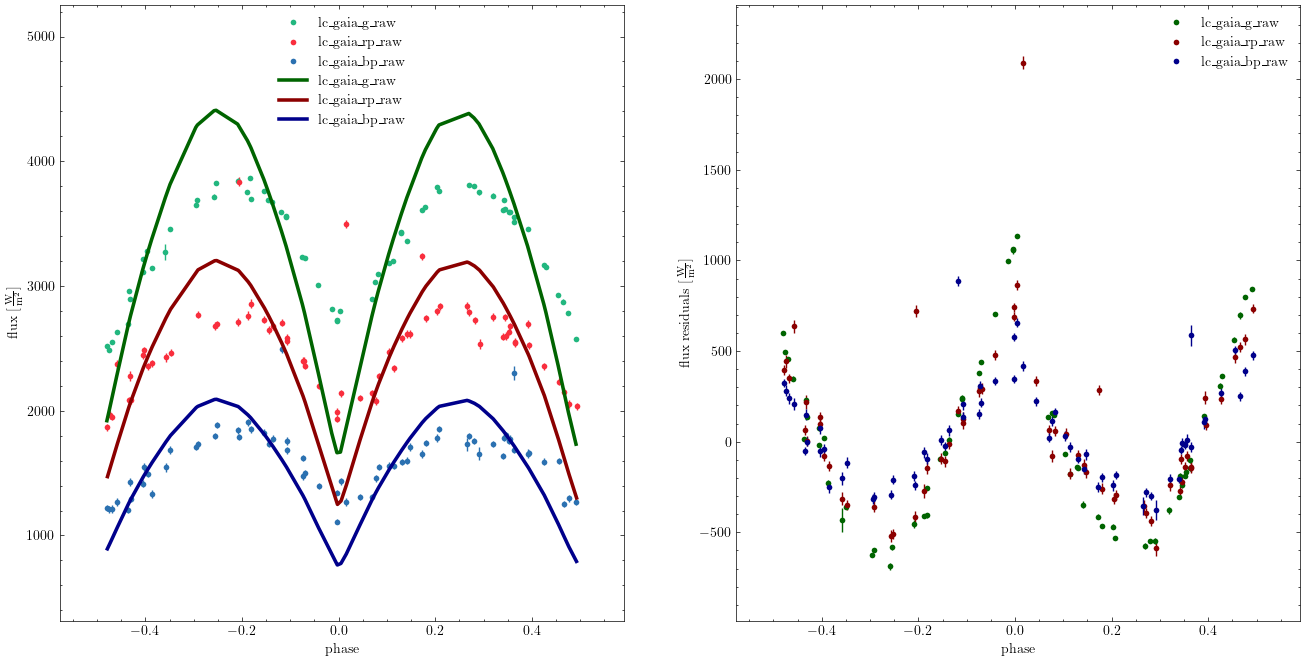

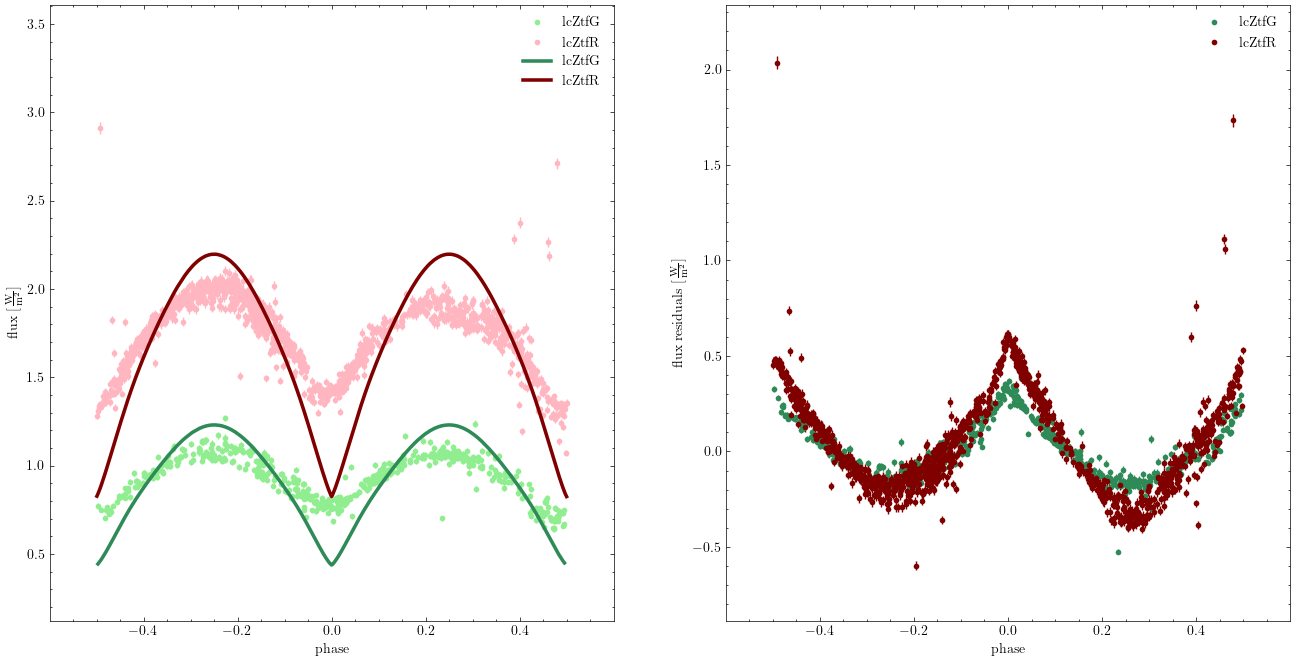

{'lc_iturbide_norm': <Figure size 1600x800 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x800 with 2 Axes>,
 'lcZtfG-lcZtfR': <Figure size 1600x800 with 2 Axes>}

In [15]:
importlib.reload(gen_utils)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='default_model')

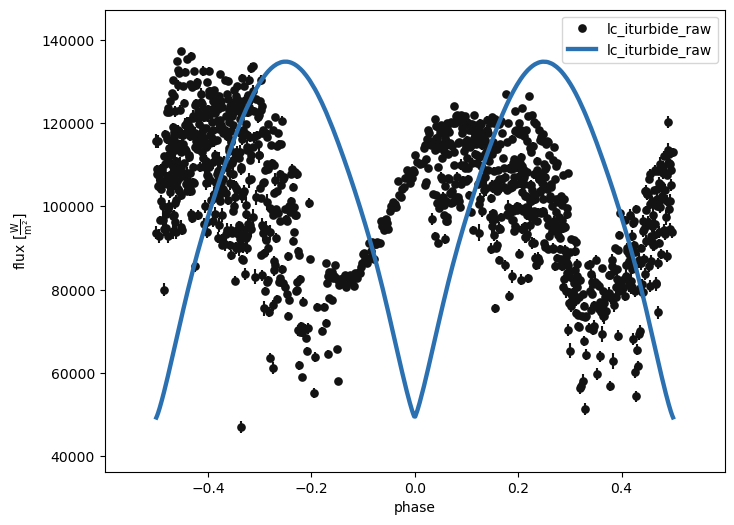

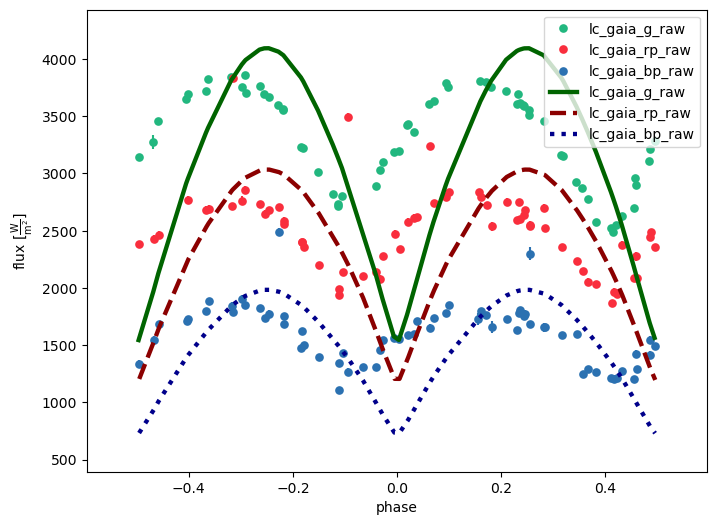

(<autofig.figure.Figure | 1 axes | 6 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [10]:
b.plot(x='phase', model='default_model', dataset='lc_iturbide_raw', kind='lc', show=True, legend=True, marker={'dataset': '.'})
b.plot(x='phase', model='default_model', dataset=rawGaiaDatasets, kind='lc', show=True, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

## EBAI KNN estimator runs

In [11]:
# ignore sklearn warnings; caused by PHOEBE internals
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Normalized datasets

In [12]:
# all normalized datasets
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_norm', lc_datasets=['lc_iturbide_norm'] + normGaiaDatasets + ztfDatasets, overwrite=True)
print(b['ebai_knn_norm'])

b.run_solver(solver='ebai_knn_norm', solution='ebai_knn_norm_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_norm_solution')
print()
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_norm_solution', {'incl@binary@orbit@component': u.rad})

ParameterSet: 7 parameters
    comments@ebai_knn_norm@solver: 
   use_server@ebai_knn_norm@so...: none
   lc_datasets@ebai_knn_norm@s...: ['lc_iturbide_norm', 'lc_gaia_g_norm', 'lc_gaia_rp_norm', 'lc_gaia_bp_norm', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_norm@so...: median
   phase_bin@ebai_knn_norm@solver: False
   ebai_method@ebai_knn_norm@s...: knn
       orbit@ebai_knn_norm@solver: binary


Tue, 05 Dec 2023 17:29 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Tue, 05 Dec 2023 17:29 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


t0_supconj@binary@orbit@component = 0.05175 d
teffratio@binary@orbit@component = 0.59953 
incl@binary@orbit@component = 0.62506 rad
fillout_factor@contact_envelope@envelope@component = 0.60662 
q@binary@orbit@component = 6.41170 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 1.5707963267948966 rad
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [13]:
# normalized Gaia datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_gaia_norm', lc_datasets=normGaiaDatasets, overwrite=True)
try:
	b.run_solver(solver='ebai_knn_gaia_norm', solution='ebai_knn_gaia_norm_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_gaia_norm_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_gaia_norm_solution', {'incl@binary': u.rad})
except TypeError as e:
	print("Failed to generate estimation for normalized Gaia data", e, sep='\n')

t0_supconj@binary@orbit@component = -0.03748 d
teffratio@binary@orbit@component = 0.98573 
incl@binary@orbit@component = 1.24048 rad
fillout_factor@contact_envelope@envelope@component = 0.18522 
q@binary@orbit@component = 1.85648 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [14]:
# normalized ZTF datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_ztf_norm', lc_datasets=ztfDatasets, overwrite=True)
try:
	b.run_solver(solver='ebai_knn_ztf_norm', solution='ebai_knn_ztf_norm_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_ztf_norm_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_ztf_norm_solution', {'incl@binary': u.rad})
except TypeError as e:
	print("Failed to generate estimation for normalized Gaia data", e, sep='\n')

t0_supconj@binary@orbit@component = 0.09659 d
teffratio@binary@orbit@component = 0.95624 
incl@binary@orbit@component = 1.28869 rad
fillout_factor@contact_envelope@envelope@component = 0.60181 
q@binary@orbit@component = 7.85028 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


### Raw datasets

In [15]:
b.datasets

['mesh01',
 'lc_iturbide_norm',
 'lc_iturbide_raw',
 'lc_iturbide_aviles_norm',
 'lc_iturbide_aviles_raw',
 'lc_gaia_g_norm',
 'lc_gaia_rp_norm',
 'lc_gaia_bp_norm',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw',
 'lcZtfG',
 'lcZtfR']

In [16]:
# all raw datasets
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw', lc_datasets=['lc_iturbide_raw', 'lc_iturbide_aviles_raw'] + rawGaiaDatasets, overwrite=True)

try:
	b.run_solver(solver='ebai_knn_raw', solution='ebai_knn_raw_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_raw_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_raw_solution', {'incl@binary@orbit@component': u.rad})
except Exception as e:
	print("Couldn't generate an estimator result using raw datasets", e, sep='\n')

2G model CGE failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Couldn't generate an estimator result using raw datasets
TwoGaussianModel.cge() missing 5 required positional arguments: 'mu', 'd', 'sigma', 'Aell', and 'phi0'


In [17]:
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_iturbide_raw', lc_datasets=['lc_iturbide_raw'], overwrite=True)
try:
	b.run_solver(solver='ebai_knn_iturbide_raw', solution='ebai_knn_iturbide_raw_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_lc_iturbide_raw_solution')
except Exception as e:
	print("Couldn't generate an estimator result using lc_iturbide_raw", e, sep='\n')

2G model CG failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Couldn't generate an estimator result using lc_iturbide_raw
TwoGaussianModel.cg() missing 3 required positional arguments: 'mu', 'd', and 'sigma'


In [18]:
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_iturbide_aviles_raw', lc_datasets=['lc_iturbide_aviles_raw'], overwrite=True)
try:
	b.run_solver(solver='ebai_knn_iturbide_aviles_raw', solution='ebai_knn_iturbide_aviles_raw_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_iturbide_aviles_raw_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_iturbide_aviles_raw_solution', {'incl@binary': u.rad})
except Exception as e:
	print("Couldn't generate an estimator result using lc_iturbide_aviles_raw", e, sep='\n')

t0_supconj@binary@orbit@component = -0.05120 d
teffratio@binary@orbit@component = 0.99171 
incl@binary@orbit@component = 1.23860 rad
fillout_factor@contact_envelope@envelope@component = 0.23329 
q@binary@orbit@component = 2.11032 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [19]:
# raw Gaia datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw_gaia', lc_datasets=rawGaiaDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_raw_gaia', solution='ebai_knn_raw_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_raw_gaia_solution')
print()
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_raw_gaia_solution', {'incl@binary': u.rad})

t0_supconj@binary@orbit@component = -0.03748 d
teffratio@binary@orbit@component = 0.98573 
incl@binary@orbit@component = 1.24048 rad
fillout_factor@contact_envelope@envelope@component = 0.18522 
q@binary@orbit@component = 1.85648 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [20]:
print(b['teffratio'])
print(b['fillout_factor'])
print(b['teff'])

ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
ParameterSet: 3 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.28797874126 high=5826.3071827964195 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


In [21]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

## Testing fit of each solution

### Temporary back up
Storing the original bundle results in memory, in case need to revert arises

In [22]:
backupBundle = b.copy()

In [ ]:
%%script echo "skipping; comment this out if we need to reset to previous state"
b = backupBundle.copy()

skipping; comment this out if we need to reset to previous state


In [23]:
b.solutions, b.solvers, b.models

(['ebai_knn_norm_solution',
  'ebai_knn_gaia_norm_solution',
  'ebai_knn_ztf_norm_solution',
  'ebai_knn_iturbide_aviles_raw_solution',
  'ebai_knn_raw_gaia_solution'],
 ['ebai_knn_norm',
  'ebai_knn_gaia_norm',
  'ebai_knn_ztf_norm',
  'ebai_knn_raw',
  'ebai_knn_iturbide_raw',
  'ebai_knn_iturbide_aviles_raw',
  'ebai_knn_raw_gaia'],
 ['default_model'])

### Checking solution goodness of fit

In [24]:
b.set_value_all(qualifier='enabled', value=True)

# using only raw datasets right now
# gen_utils.abilitateDatasets(b, allRawDatasets)

print(b['enabled'])

ParameterSet: 13 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_gaia_g_norm@phoe...: True
   enabled@lc_gaia_rp_norm@pho...: True
   enabled@lc_gaia_bp_norm@pho...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [25]:
print(b['requiv'])
print(b['sma@binary'])
print(b['ntriangles'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.5 solRad
C      requiv@secondary@component: 1.4999999999999996 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C            sma@binary@component: 3.35 solRad
            sma@binary@constraint: (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3)
Parameter: ntriangles@contact_envelope@phoebe01@compute
                       Qualifier: ntriangles
                     Description: Requested number of triangles (won't be exact).
                           Value: 3000
                  Constrained by: 
                      Constrains: None
          

In [26]:
b.set_value(qualifier='ntriangles', value=4000) # originally 3000
print(b['ntriangles'])

Parameter: ntriangles@contact_envelope@phoebe01@compute
                       Qualifier: ntriangles
                     Description: Requested number of triangles (won't be exact).
                           Value: 4000
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: mesh_method:marching,hierarchy.is_meshable:true



In [27]:
importlib.reload(gen_utils)
gen_utils.resetAtmosphere(b)
print(b['atm'])

ParameterSet: 2 parameters
     atm@primary@phoebe01@compute: ck2004
   atm@secondary@phoebe01@compute: ck2004


ebai_knn_norm_solution | ebai_knn_norm_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.05175 d
teffratio@binary@orbit@component = 0.59953 
incl@binary@orbit@component = 0.62506 rad
fillout_factor@contact_envelope@envelope@component = 0.60662 
q@binary@orbit@component = 6.41170 

Original values:
  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


Wed, 06 Dec 2023 08:40 UNIVERSE     WARNING Atmosphere parameters out of bounds: Teff=[3495.51255051 3496.59938804 3484.39968335 3473.1447584  3455.80343933
 3485.64841606 3490.05496416 3494.84278859 3487.47459841 3443.42756224
 3452.25298268 3448.88709694 3451.93877672 3399.5971102  3403.59686493
 3398.96576589 3397.24068528 3411.83668824 3451.71150451 3467.28638866
 3499.4286542  3485.85372226 3439.39160699 3394.31313868 3375.26586718
 3325.85626159 3324.31021799 3322.86536281 3463.59626367 3421.37308593
 3354.82910773 3306.70654618 3292.40435259 3271.32906814 3456.88409066
 3406.01759356 3332.71014039 3275.86832855 3465.98837024 3404.55198621
 3324.24243856 3283.9874695  3429.67595193 3362.62817853 3486.77874271
 3447.96616563 3379.63960428 3303.69530964 3460.87467719 3467.52978262
 3489.21204535 3395.0698095  3334.88406817 3405.05266628 3302.1894569
 3431.9437102  3472.28413618 3474.30443986 3428.15444757 3311.93318659
 3342.65450245 3482.97441539 3440.74432291 3369.46152742 3460.5

Failed to adopt ebai_knn_norm_solution
Could not compute ldint with ldatm='ck2004'.  Try changing atm to a table that covers a sufficient range of values.  If necessary, set atm to 'blackbody' and/or ld_mode to 'manual' (in which case coefficients will need to be explicitly provided via ld_coeffs). Enable 'warning' logger to see out-of-bound arrays.
ebai_knn_gaia_norm_solution | ebai_knn_gaia_norm_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = -0.03748 d
teffratio@binary@orbit@component = 0.98573 
incl@binary@orbit@component = 1.24048 rad
fillout_factor@contact_envelope@envelope@component = 0.18522 
q@binary@orbit@component = 1.85648 

Original values:
  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


100%|██████████| 3673/3673 [10:06<00:00,  6.06it/s]
Wed, 06 Dec 2023 08:51 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Wed, 06 Dec 2023 08:51 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


ebai_knn_gaia_norm_model chi2
	 Iturbide (Aviles) - 265597.22928488976
	 Gaia (Raw)- 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
	 Gaia (Normalized)- 19757.86303394768
		 lc_gaia_g_norm - 13229.17669350362
		 lc_gaia_rp_norm - 4308.2804640883005
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343


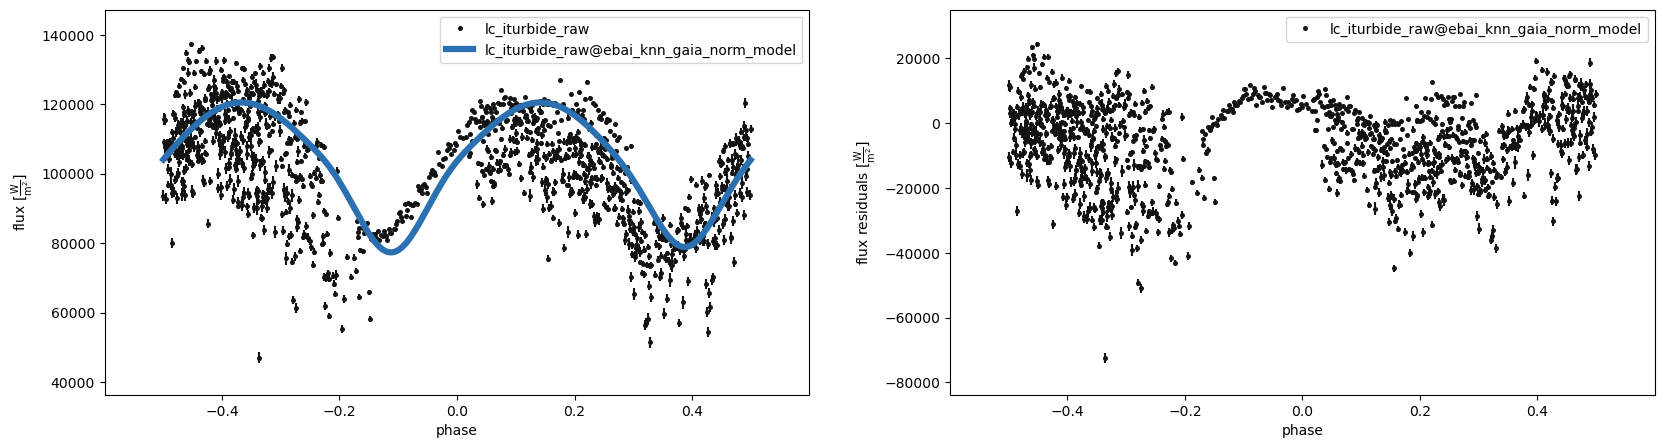

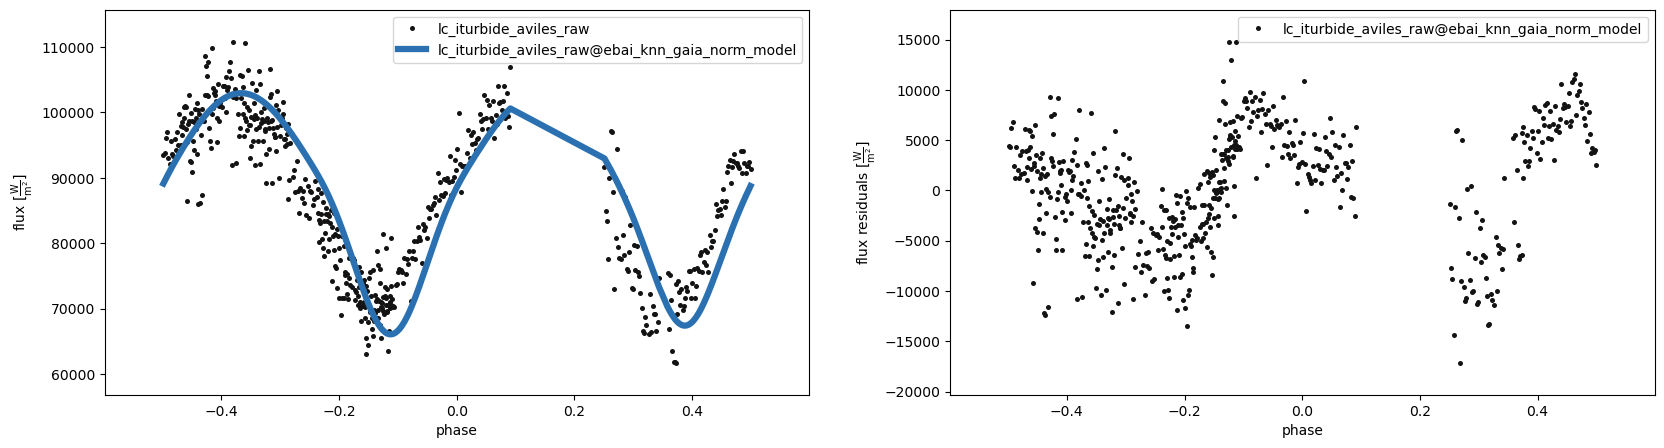

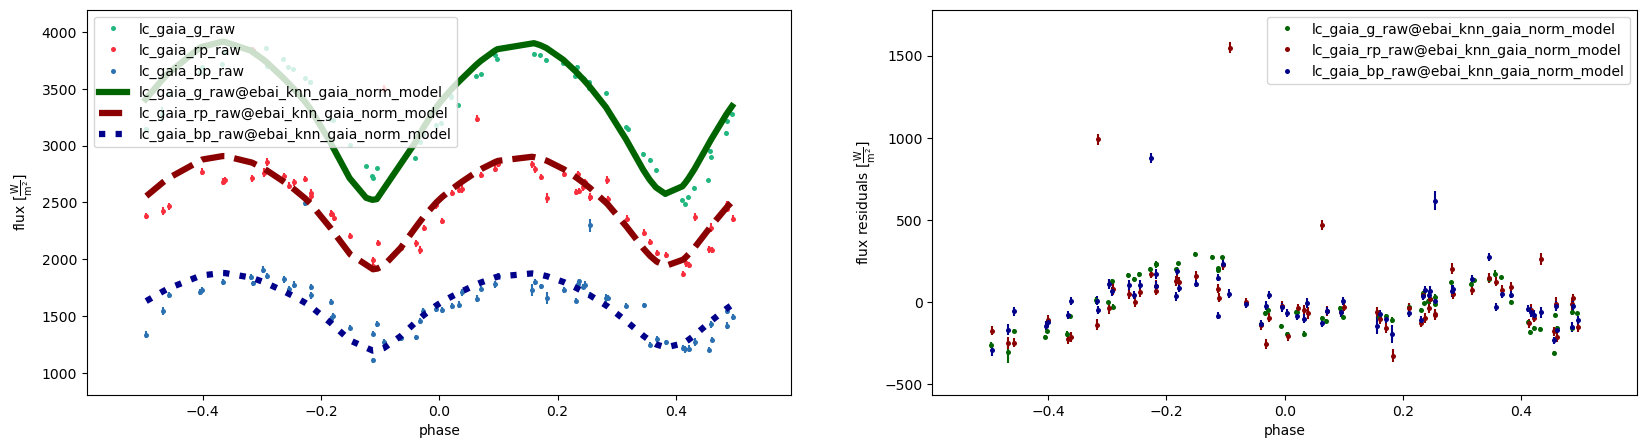

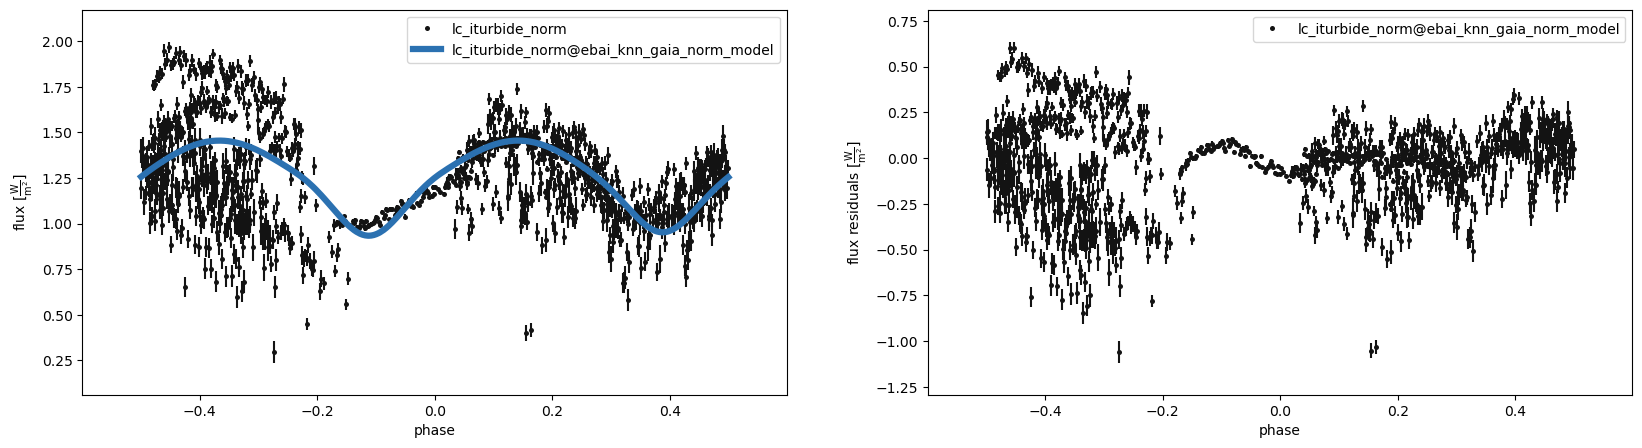

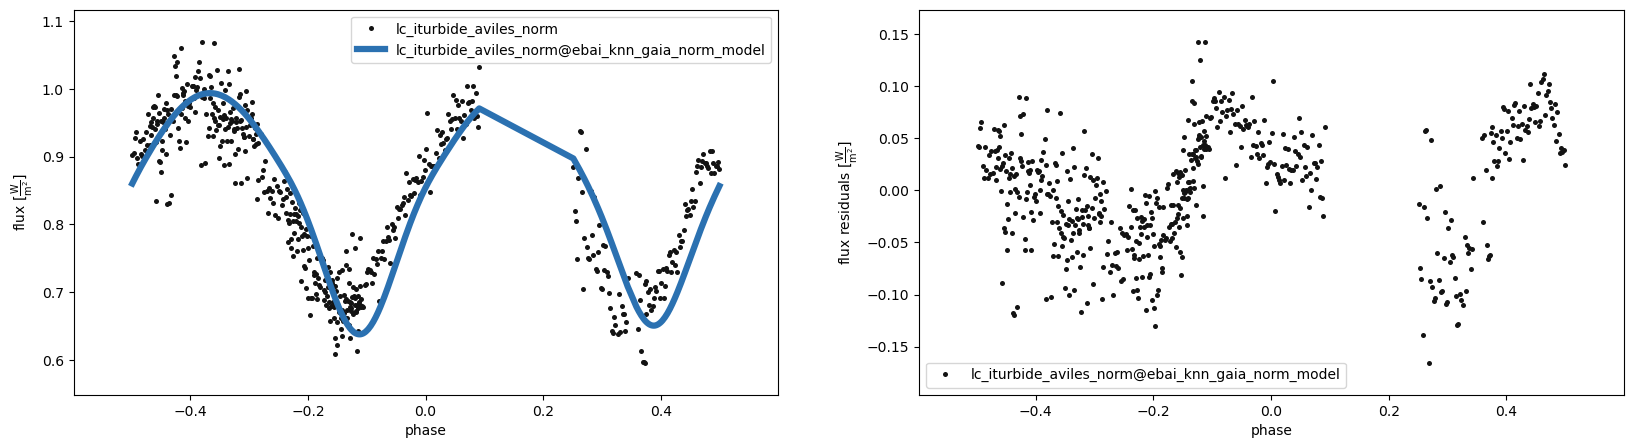

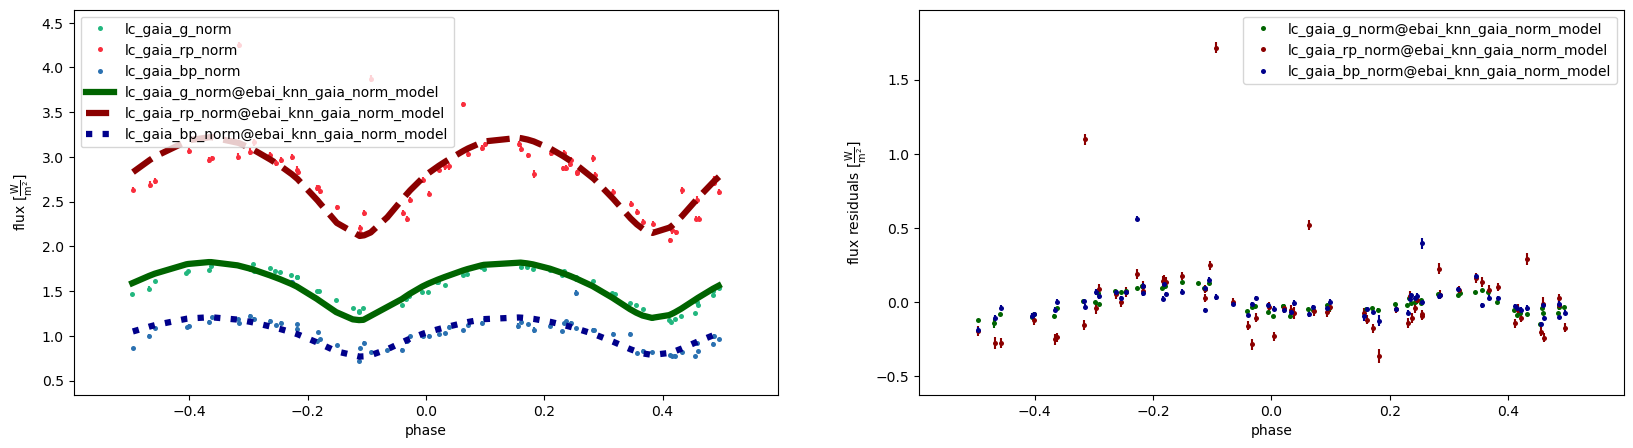

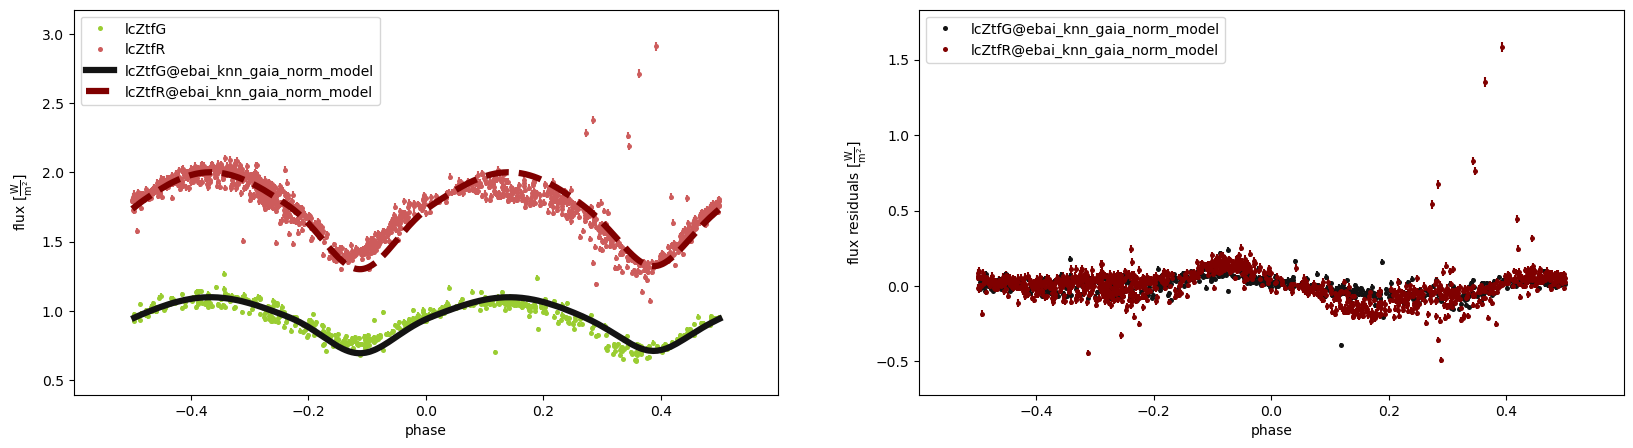

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_ztf_norm_solution | ebai_knn_ztf_norm_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09659 d
teffratio@binary@orbit@component = 0.95624 
incl@binary@orbit@component = 1.28869 rad
fillout_factor@contact_envelope@envelope@component = 0.60181 
q@binary@orbit@component = 7.85028 

Original values:
  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


100%|██████████| 3673/3673 [05:26<00:00, 11.25it/s]
Wed, 06 Dec 2023 08:59 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Wed, 06 Dec 2023 08:59 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


ebai_knn_ztf_norm_model chi2
	 Iturbide (Aviles) - 618396.8871194262
	 Gaia (Raw)- 204359.90768071386
		 lc_gaia_g_raw - 179333.56911447304
		 lc_gaia_rp_raw - 14561.049285898305
		 lc_gaia_bp_raw - 10465.289280342515
	 Gaia (Normalized)- 204359.90768071395
		 lc_gaia_g_norm - 179333.5691144731
		 lc_gaia_rp_norm - 14561.049285898338
		 lc_gaia_bp_norm - 10465.289280342511
	 ZTF - 146169.66942877212
		 lcZtfG - 28453.518052983025
		 lcZtfR - 117716.15137578911


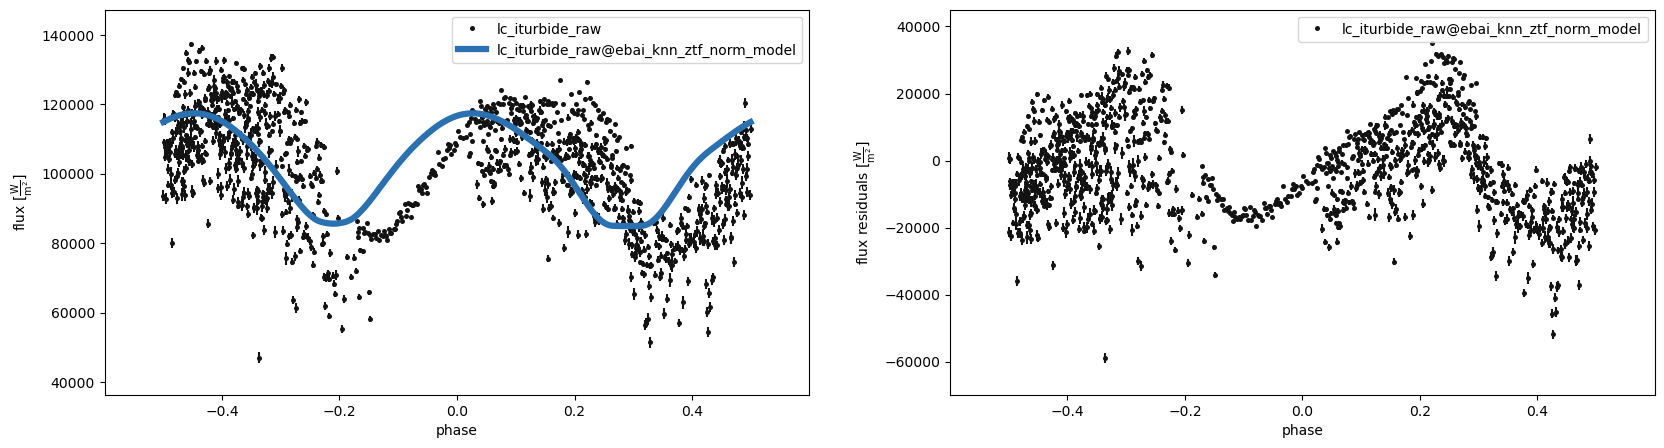

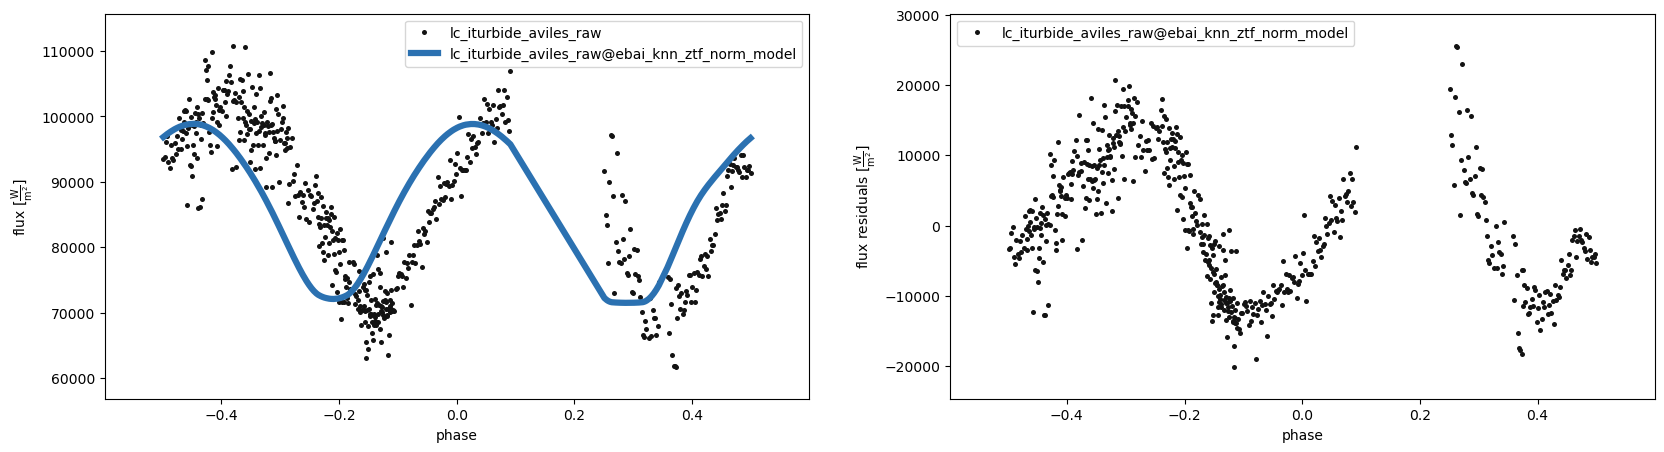

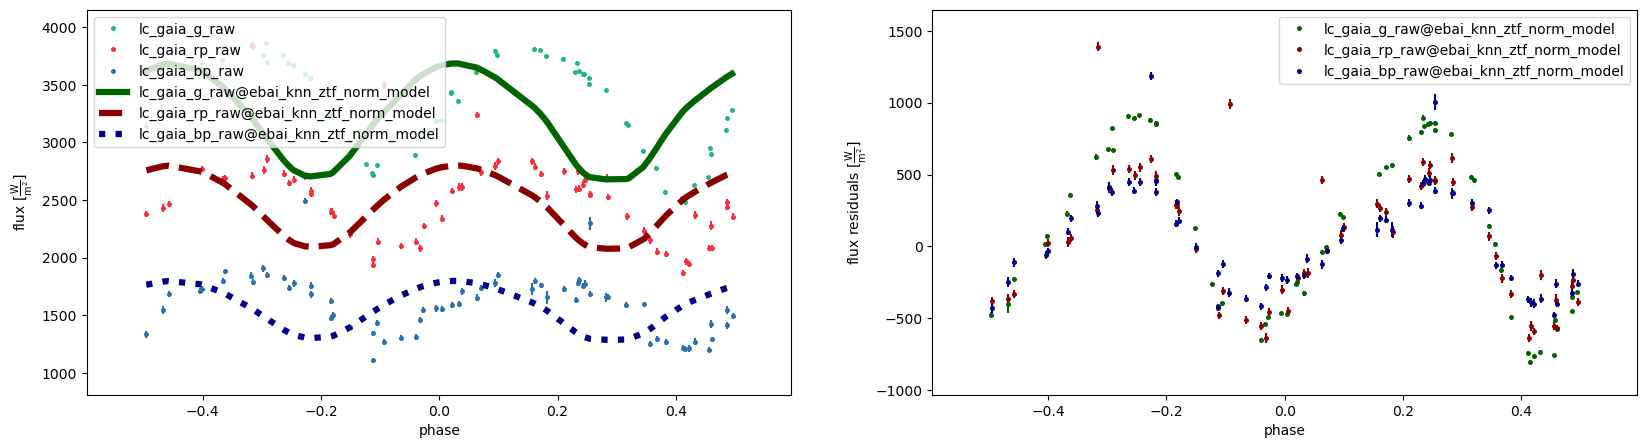

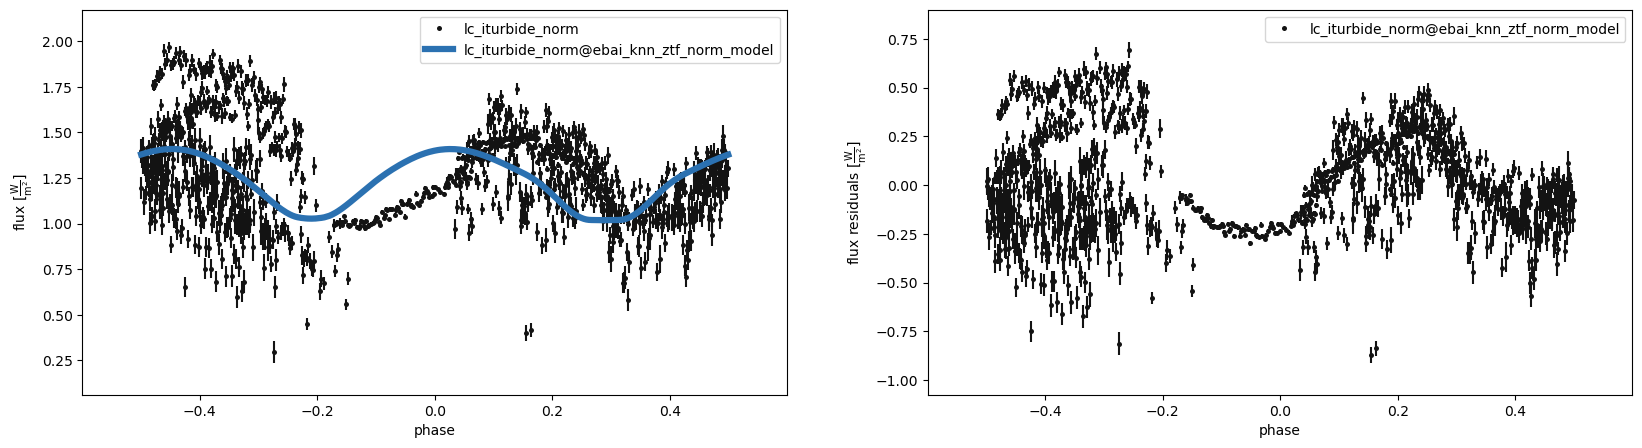

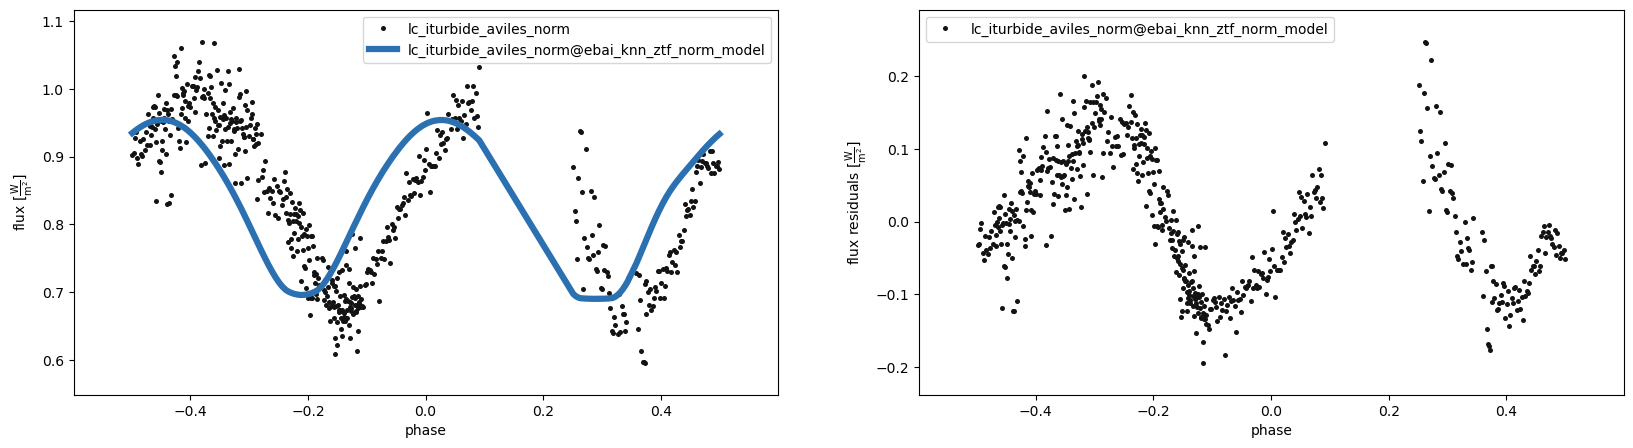

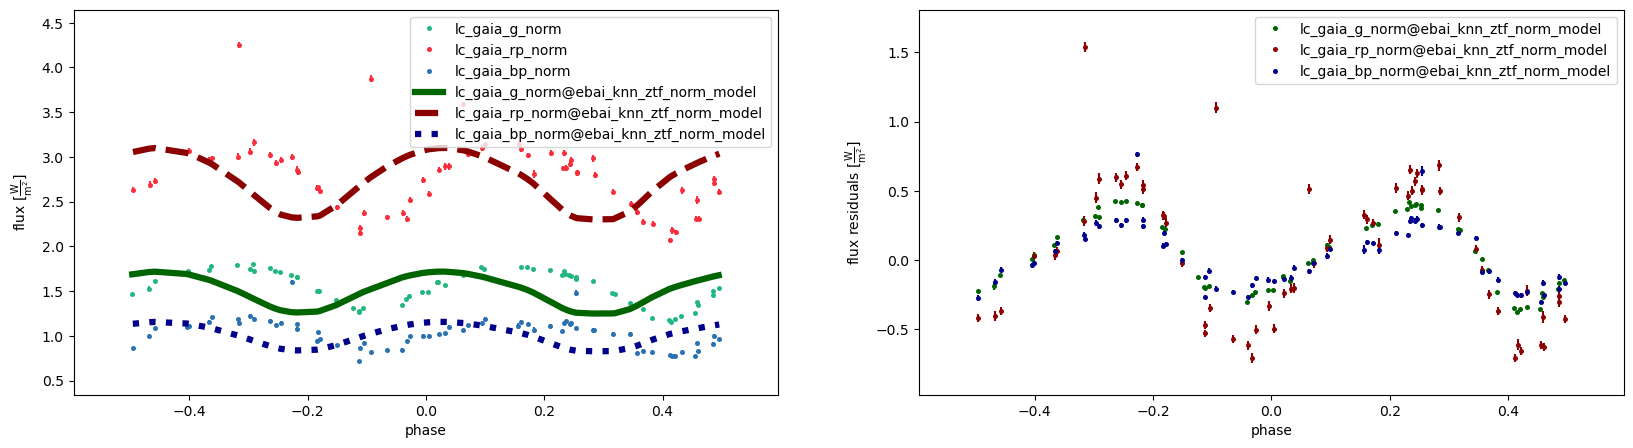

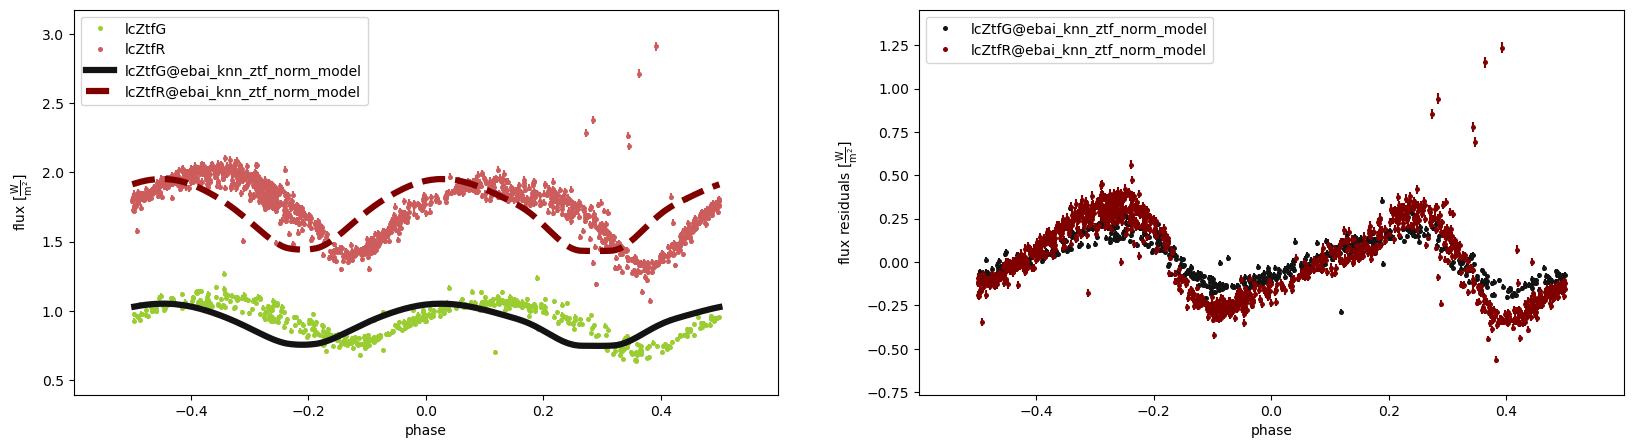

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_solution not found
ebai_knn_iturbide_raw_solution not found
ebai_knn_iturbide_aviles_raw_solution | ebai_knn_iturbide_aviles_raw_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = -0.05120 d
teffratio@binary@orbit@component = 0.99171 
incl@binary@orbit@component = 1.23860 rad
fillout_factor@contact_envelope@envelope@component = 0.23329 
q@binary@orbit@component = 2.11032 

Original values:
  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


100%|██████████| 3673/3673 [09:10<00:00,  6.68it/s]
Wed, 06 Dec 2023 09:10 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Wed, 06 Dec 2023 09:10 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


ebai_knn_iturbide_aviles_raw_model chi2
	 Iturbide (Aviles) - 210557.40352821982
	 Gaia (Raw)- 83603.07749837918
		 lc_gaia_g_raw - 70525.01637559119
		 lc_gaia_rp_raw - 7676.200762076429
		 lc_gaia_bp_raw - 5401.860360711548
	 Gaia (Normalized)- 83603.07749837931
		 lc_gaia_g_norm - 70525.01637559131
		 lc_gaia_rp_norm - 7676.200762076444
		 lc_gaia_bp_norm - 5401.860360711544
	 ZTF - 44003.457970039555
		 lcZtfG - 8729.754280458246
		 lcZtfR - 35273.70368958131


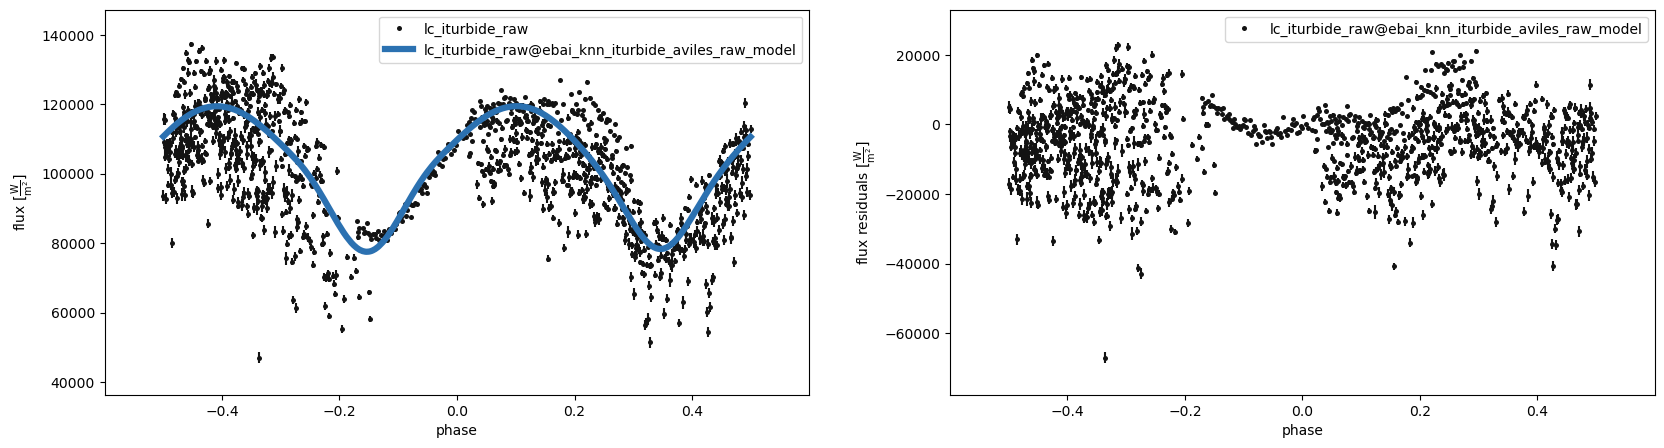

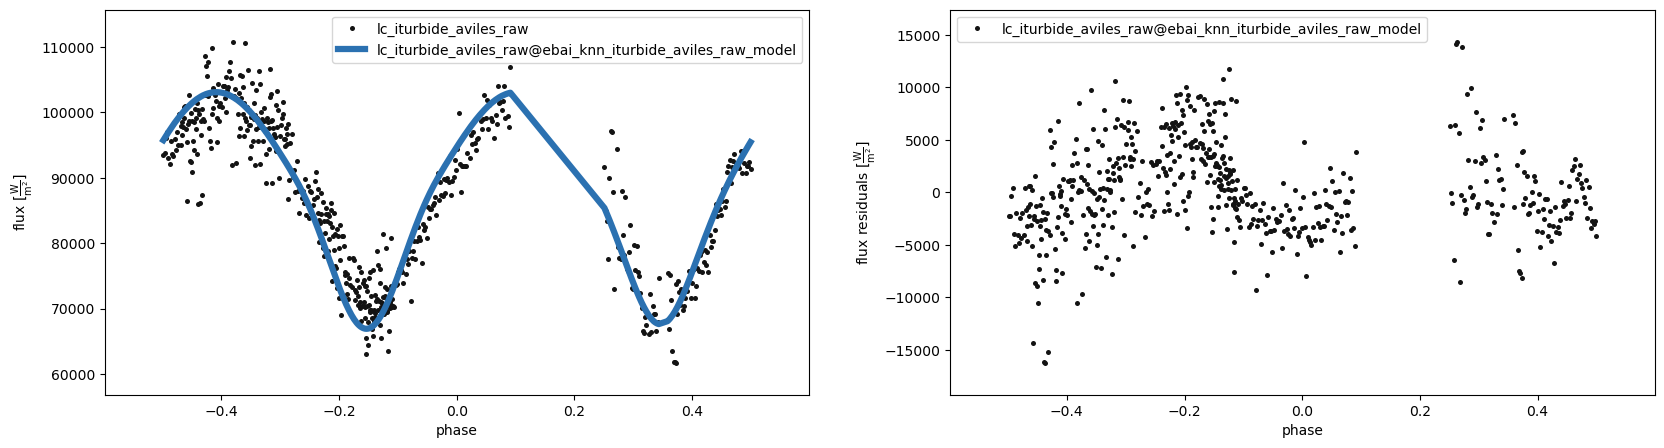

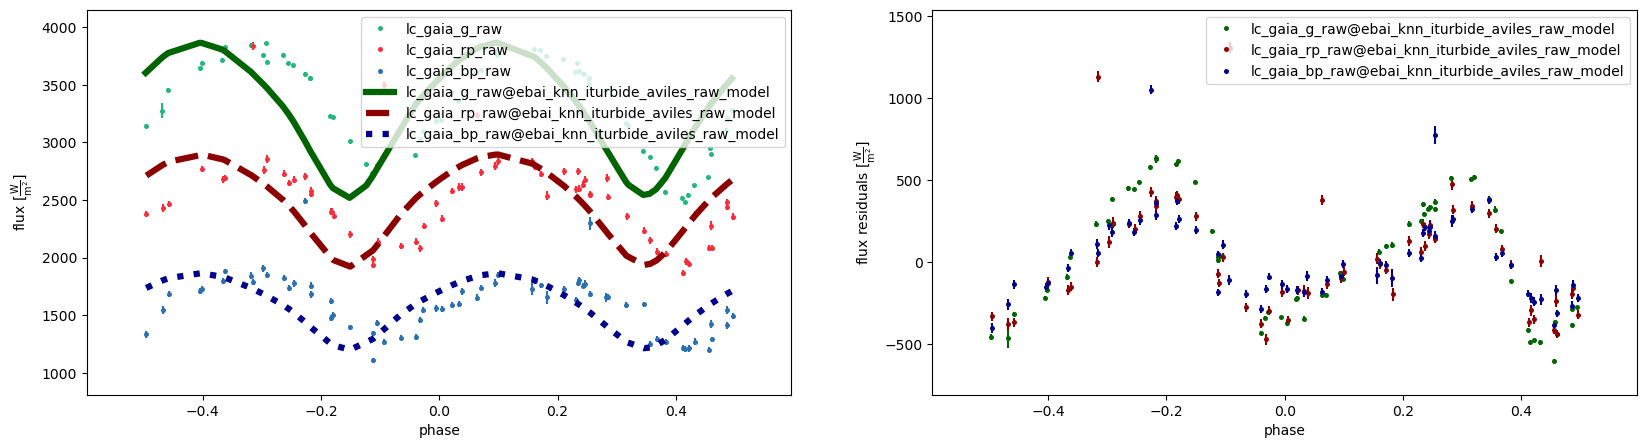

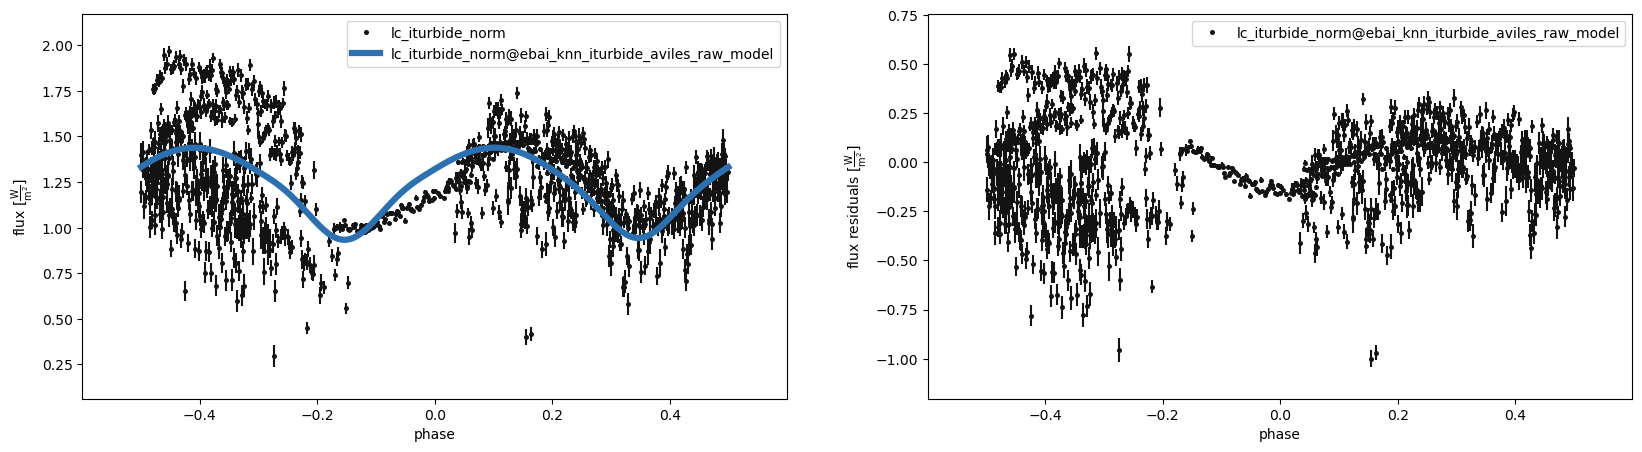

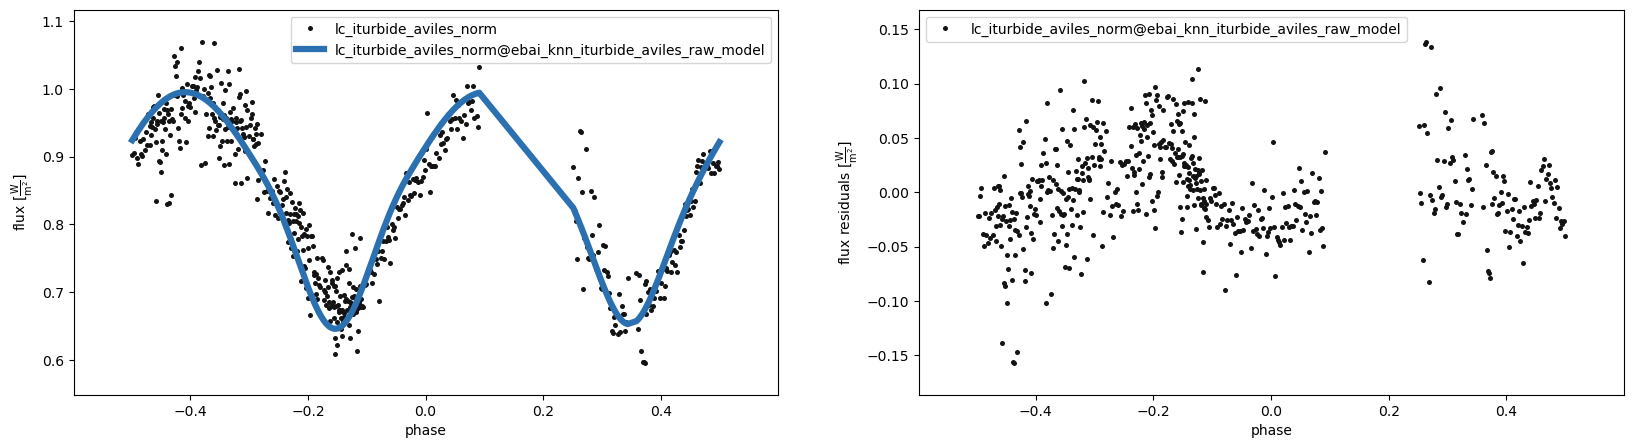

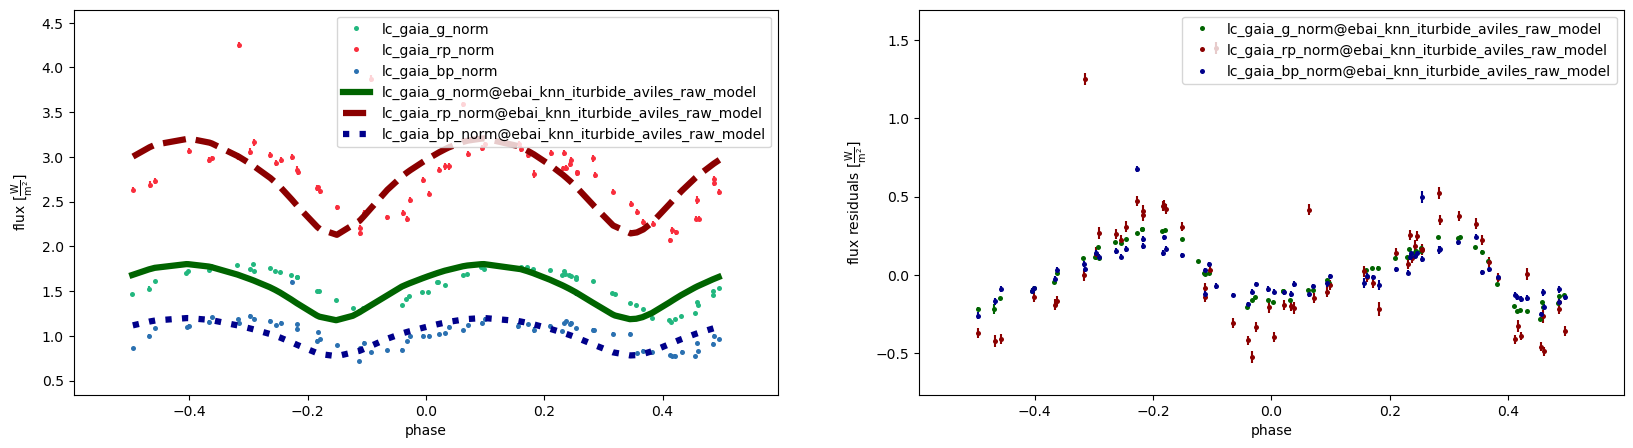

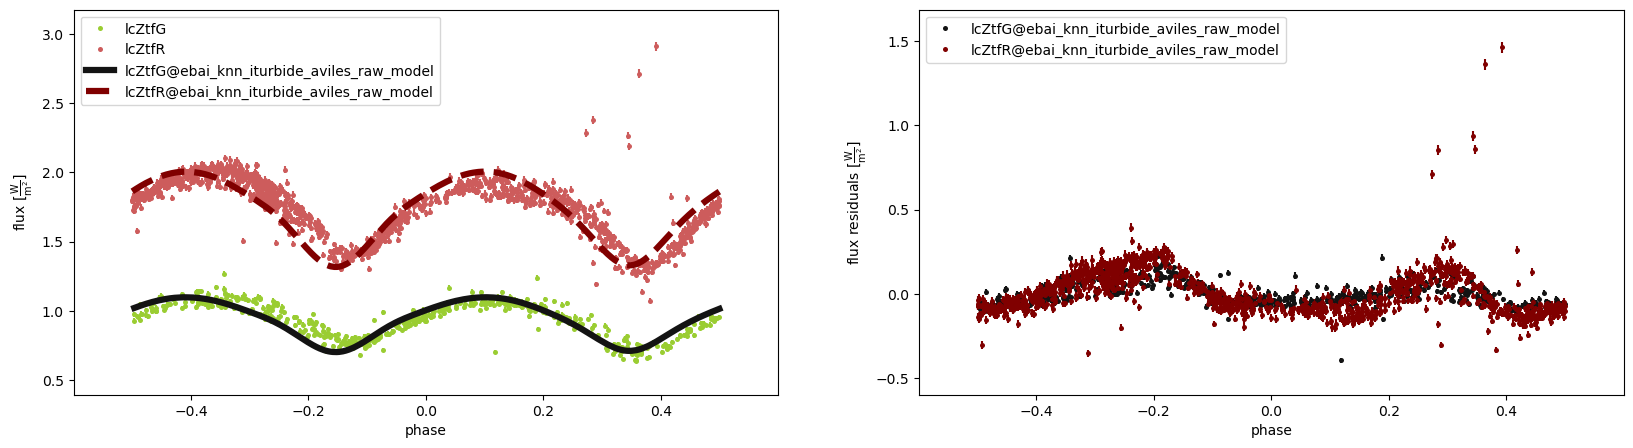

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_gaia_solution | ebai_knn_raw_gaia_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = -0.03748 d
teffratio@binary@orbit@component = 0.98573 
incl@binary@orbit@component = 1.24048 rad
fillout_factor@contact_envelope@envelope@component = 0.18522 
q@binary@orbit@component = 1.85648 

Original values:
  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


100%|██████████| 3673/3673 [08:53<00:00,  6.89it/s]
Wed, 06 Dec 2023 09:21 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Wed, 06 Dec 2023 09:21 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


ebai_knn_raw_gaia_model chi2
	 Iturbide (Aviles) - 265597.22928488976
	 Gaia (Raw)- 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
	 Gaia (Normalized)- 19757.86303394768
		 lc_gaia_g_norm - 13229.17669350362
		 lc_gaia_rp_norm - 4308.2804640883005
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343


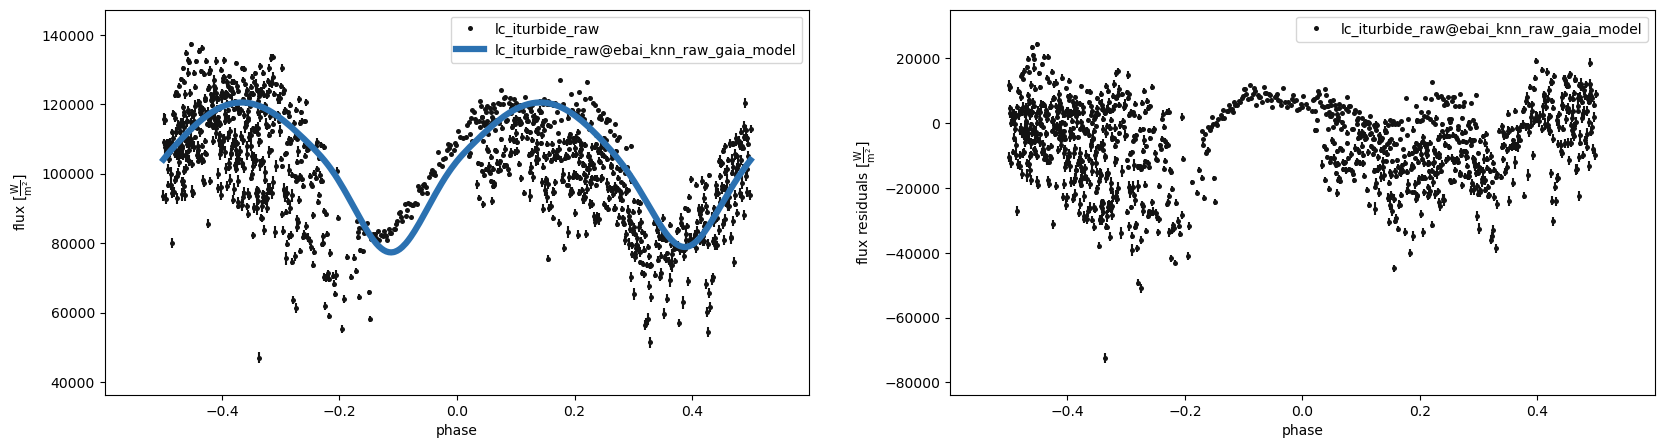

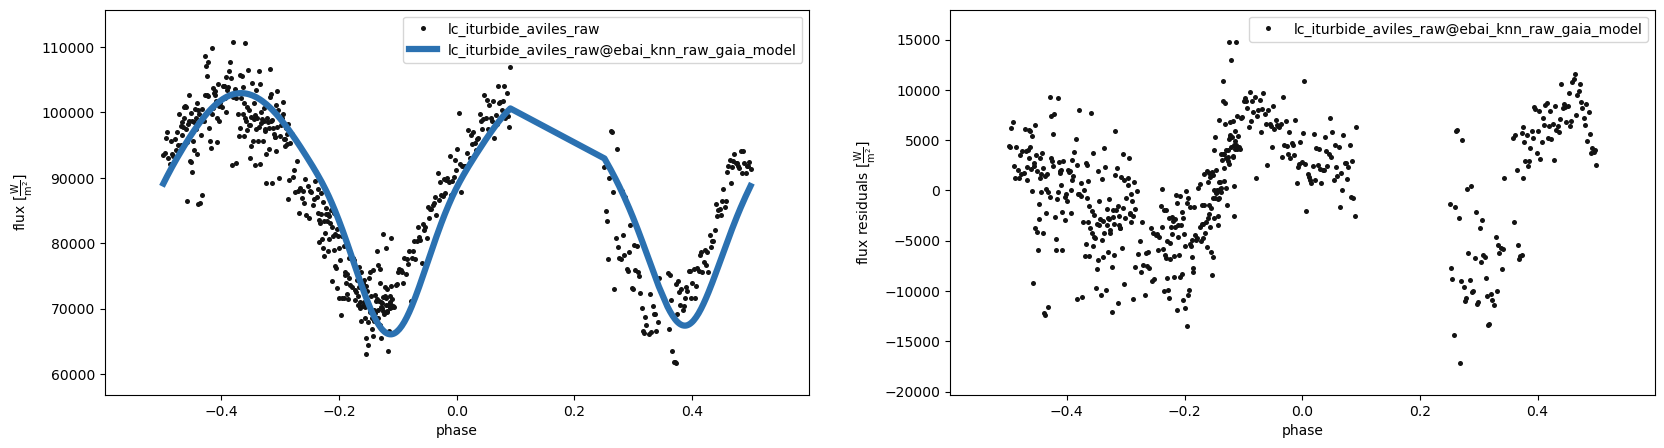

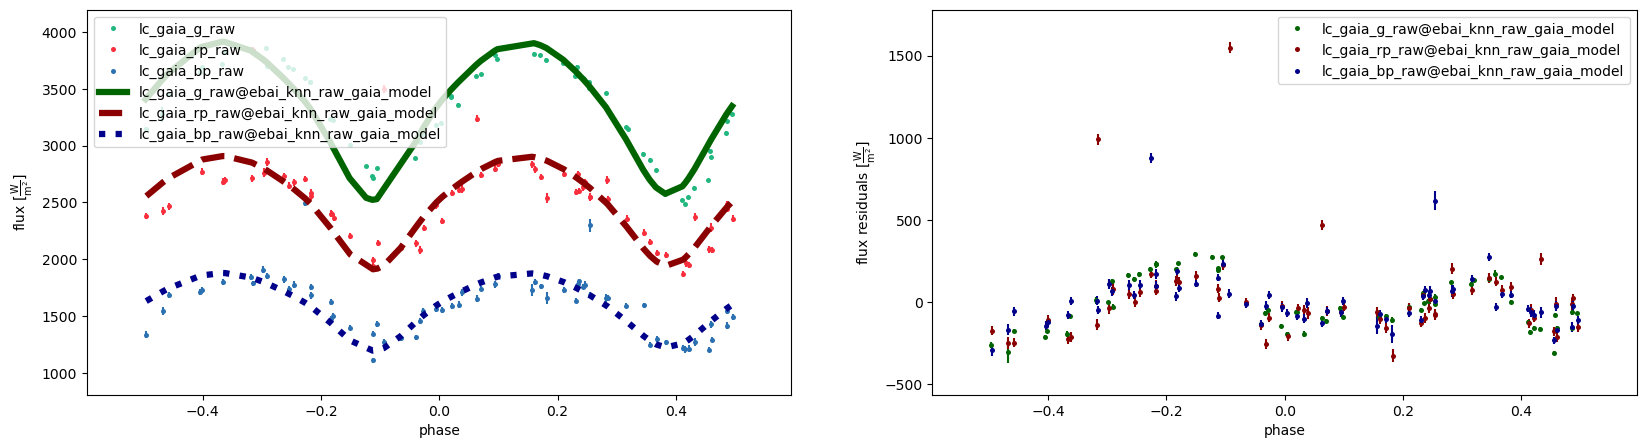

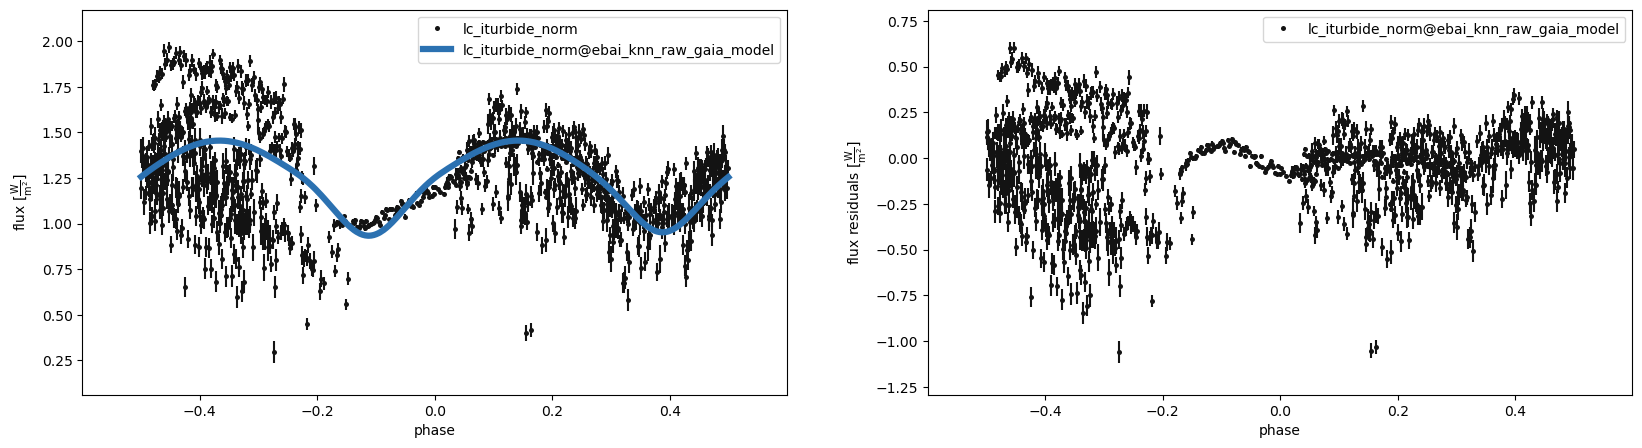

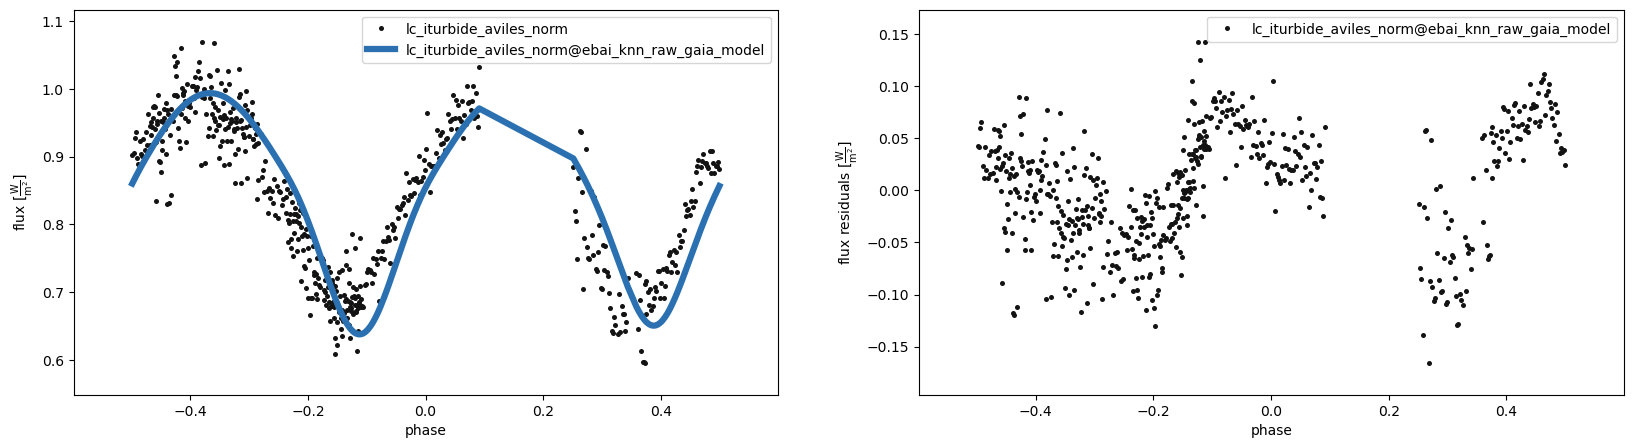

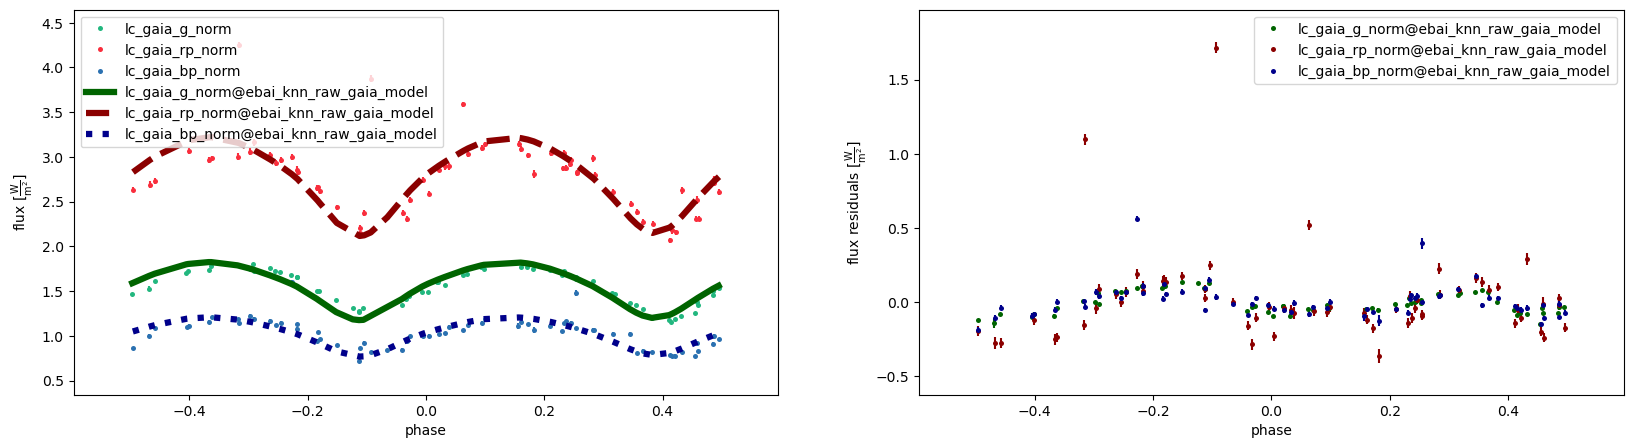

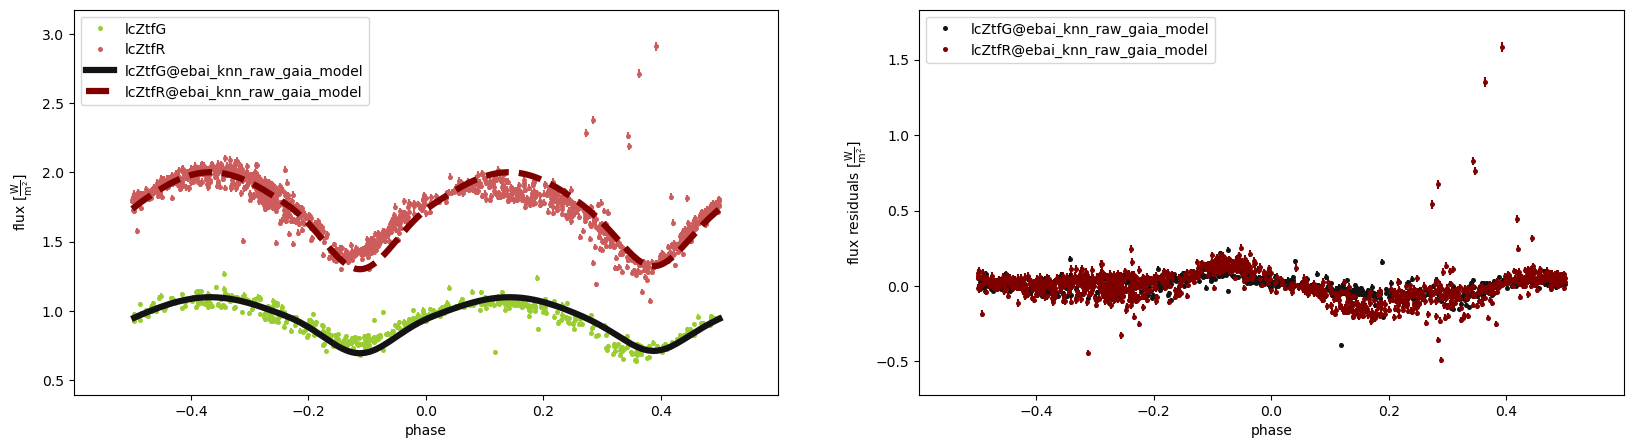

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [28]:
PLOT_MODELS = True
ANIMATE = True
SAVE_BINARY_ANIMATION = True

for solver in [s for s in b.solvers if 'ebai_knn' in s]:
	solution = f"{solver}_solution"
	model = f"{solver}_model"

	# skipping any failed solvers
	if solution not in b.solutions:
		print("================================================")
		print(f"{solution} not found")
		print("================================================")
		continue

	print(solution, "|", model)
	print("------------------------------------------------")

	try:
		gen_utils.adopt_solution(b, solution, model_name=model, reset_params=True, run_compute=not model in b.models)
	except Exception as e:
		print("=====================================")
		print(f"Failed to adopt {solution}", e, sep='\n')
		print("=====================================")
		b.remove_model(model)
		continue

	# gen_utils.printFittedVals(b, solution)
	# if model not in b.models:
	# 	try:
	# 		b.adopt_solution(solution=solution)
	# 		b.run_compute(model=model, compute='phoebe01', overwrite=True)
	# 	except Exception as e:
	# 		print(f"Failed to run {model} compute", e)
	# 		continue


	# print("Total residuals")

	# for all datasets, including normalized ones
	# for d in b.datasets:
	# 	if d == 'mesh01':
	# 		continue
	# 	print("\t", d, np.sum(b.calculate_residuals(model=model, dataset=d)))

	# for d in allRawDatasets:
	# 	print("\t", d, np.sum(b.calculate_residuals(model=model, dataset=d)))
	
	printChi2(b, model)

	# b.plot(x='phase', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=1)
	# b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=2)
	# b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=3)

	# b.plot(x='phase', y='residuals', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker='.', s=0.008, axorder=4)
	# b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=5)
	# b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=6, subplot_grid=(3,3), save=f"./graphs/ebai/{solver}")

	if PLOT_MODELS:
		plotDatasetGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets, 
					   		['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets]
		gen_utils.plotModelResidualsFigsize(b, figsize=(20, 5), datasetGroups=plotDatasetGroups, model=model)
		
		# b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=1)
		# b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=2, color=gen_utils.GAIA_RAW_PLOT_COLORS)

		# b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=3)
		# b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=4, subplot_grid=(2,2), save=f"./graphs/raw_only/ebai/{solver}" if SAVE_PLOTS else None, color=gen_utils.GAIA_RAW_PLOT_COLORS)

		if ANIMATE:
			gen_utils.displayAnims(1, 3, 
					# gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/raw_only/anims/{solver}.gif" if SAVE_BINARY_ANIMATION else None),
					gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/iturbide-gaia-ztf-ltt/anims/{solver}.gif" if SAVE_BINARY_ANIMATION else None),
					gen_utils.genAnimatedMesh(b, logger, model=model, component='primary', draw_title=True, title=f"{model} - Primary"),
					gen_utils.genAnimatedMesh(b, logger, model=model, component='secondary', draw_title=True, title=f"{model} - Secondary"))

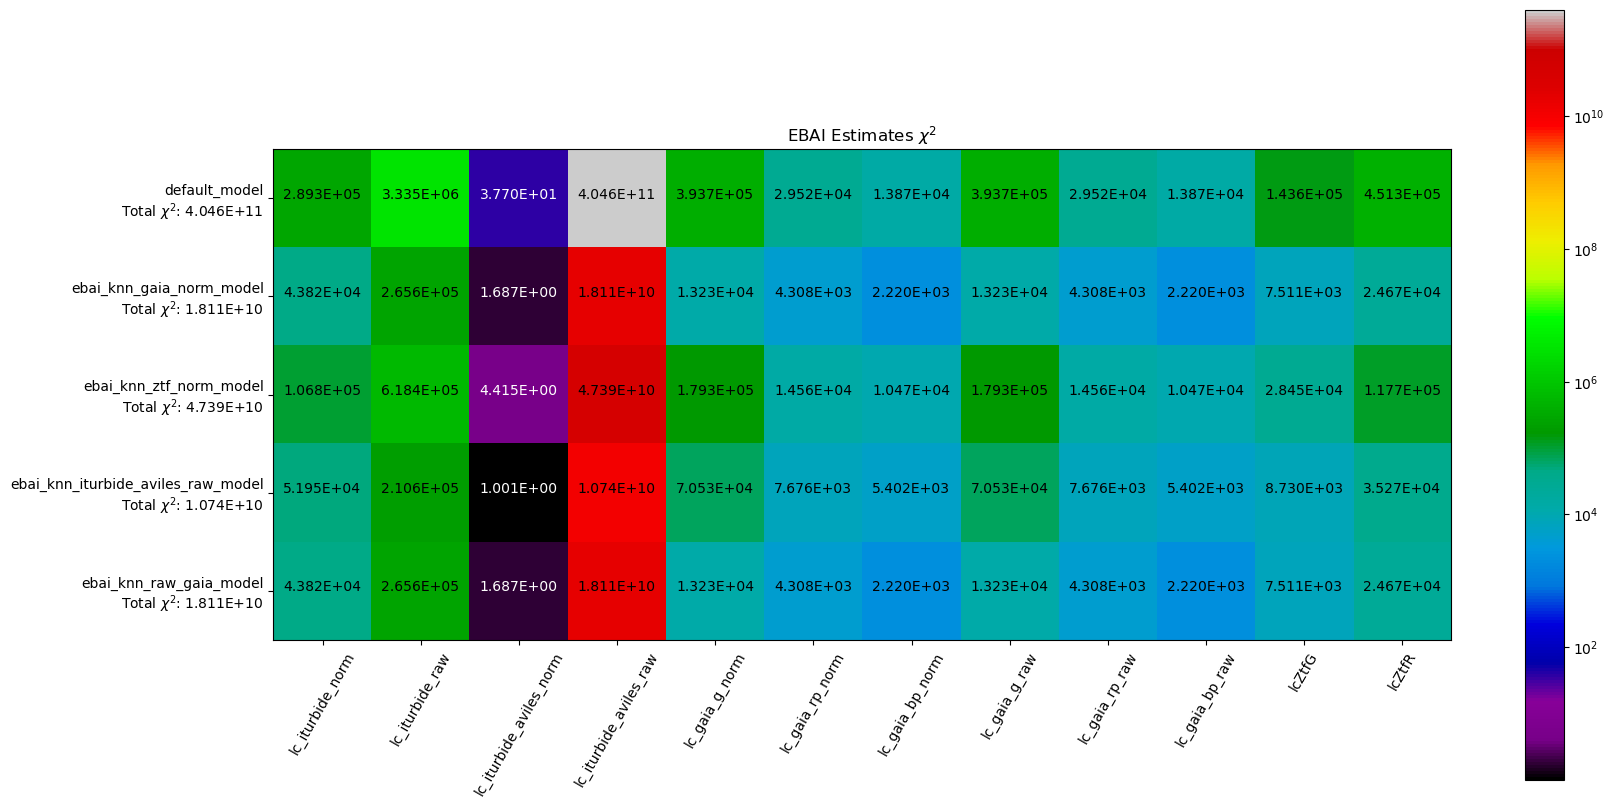

In [29]:
from matplotlib.colors import LogNorm

# ebaiModels = [m for m in b.models if 'ebai_knn' in m]
comparisonModels = b.models
datasets = [d for d in b.datasets if 'mesh' not in d]

modelsDatasetsMatrix = np.zeros(shape=(len(comparisonModels), len(datasets)))

for m_idx, model in enumerate(comparisonModels):
	for d_idx, dataset in enumerate(datasets):
		modelsDatasetsMatrix[m_idx, d_idx] = np.sum(b.calculate_chi2(model=model, dataset=dataset))

plt.figure(figsize=(19, 10))
plt.imshow(modelsDatasetsMatrix, norm=LogNorm(), cmap='nipy_spectral')
for m_idx in range(len(comparisonModels)):
	for d_idx in range(len(datasets)):
		chi2 = modelsDatasetsMatrix[m_idx, d_idx]
		plt.text(d_idx - 0.4, m_idx, '%.3E' % chi2, color='black' if chi2 > 1e3 else 'white')

plt.xticks(np.arange(len(datasets), dtype=int), datasets, rotation=60)

yticks = []
for m_idx, model in enumerate(comparisonModels):
	yticks.append(f"{model}\nTotal $\\chi^2$: %.3E" % np.sum(modelsDatasetsMatrix[m_idx, :]))
plt.yticks(np.arange(len(comparisonModels), dtype=int), yticks)
plt.title("EBAI Estimates $\chi^2$")
plt.colorbar()

In [30]:
for s in b.solutions:
	print(s, "-------------------------", sep='\n')
	gen_utils.printFittedVals(b, s)
	print("Datasets:", b[f'value@{s.replace("_solution", "")}@lc_datasets'])
	print()

# raw-Gaia and norm-Gaia give same solutions; interchangeable

ebai_knn_norm_solution
-------------------------
t0_supconj@binary@orbit@component = 0.05175 d
teffratio@binary@orbit@component = 0.59953 
incl@binary@orbit@component = 0.62506 rad
fillout_factor@contact_envelope@envelope@component = 0.60662 
q@binary@orbit@component = 6.41170 
Datasets: ['lc_iturbide_norm', 'lc_gaia_g_norm', 'lc_gaia_rp_norm', 'lc_gaia_bp_norm', 'lcZtfG', 'lcZtfR']

ebai_knn_gaia_norm_solution
-------------------------
t0_supconj@binary@orbit@component = -0.03748 d
teffratio@binary@orbit@component = 0.98573 
incl@binary@orbit@component = 1.24048 rad
fillout_factor@contact_envelope@envelope@component = 0.18522 
q@binary@orbit@component = 1.85648 
Datasets: ['lc_gaia_g_norm', 'lc_gaia_rp_norm', 'lc_gaia_bp_norm']

ebai_knn_ztf_norm_solution
-------------------------
t0_supconj@binary@orbit@component = 0.09659 d
teffratio@binary@orbit@component = 0.95624 
incl@binary@orbit@component = 1.28869 rad
fillout_factor@contact_envelope@envelope@component = 0.60181 
q@binary@orbi

In [22]:
gen_utils.printFittedVals(b, solution='ebai_knn_gaia_norm_solution')
print()
gen_utils.printFittedTwigsConstraints(b, solution='ebai_knn_gaia_norm_solution', units={'incl@binary@orbit@component': u.deg})

t0_supconj@binary@orbit@component -0.03748 d 
teffratio@binary@orbit@component 0.98573  
incl@binary@orbit@component 1.24048 rad 
fillout_factor@contact_envelope@envelope@component 0.18522  
q@binary@orbit@component 1.85648  

  t0_supconj@binary@orbit@component -0.03748 d 
  teffratio@binary@orbit@component 0.98573 
  incl@binary@orbit@component 71.07442 deg 
  fillout_factor@contact_envelope@envelope@component 0.18522 
  q@binary@orbit@component 1.85648 


In [11]:
b.run_compute(model='ebai_knn_gaia_raw_model', overwrite=True)

100%|██████████| 3673/3673 [08:32<00:00,  7.16it/s]
Thu, 25 Jan 2024 14:17 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Thu, 25 Jan 2024 14:17 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


<ParameterSet: 199 parameters | kinds: lc, mesh>

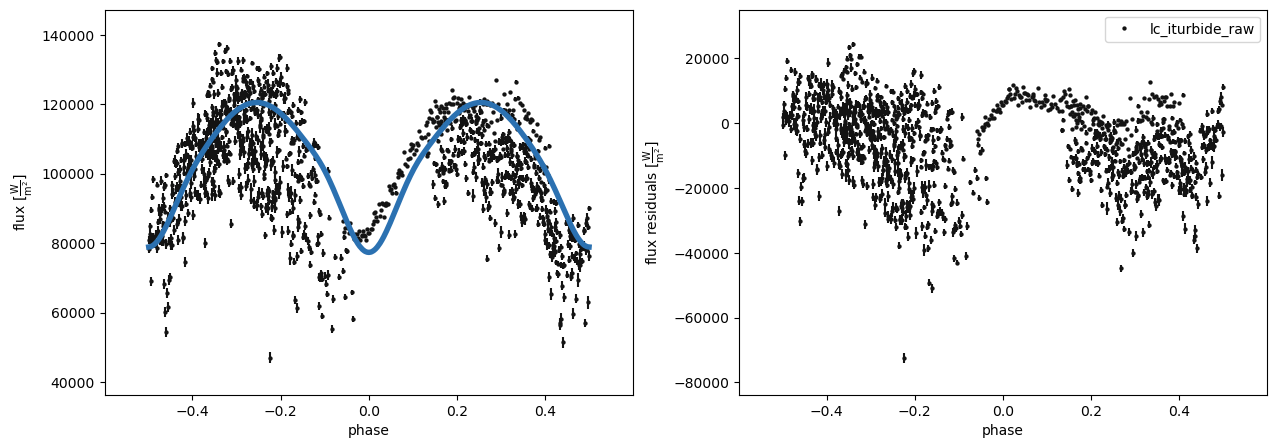

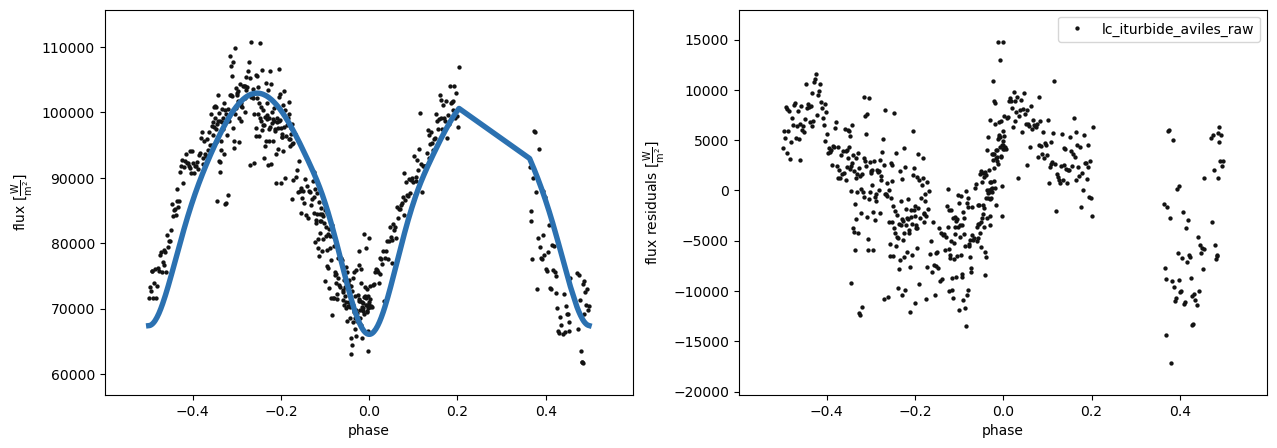

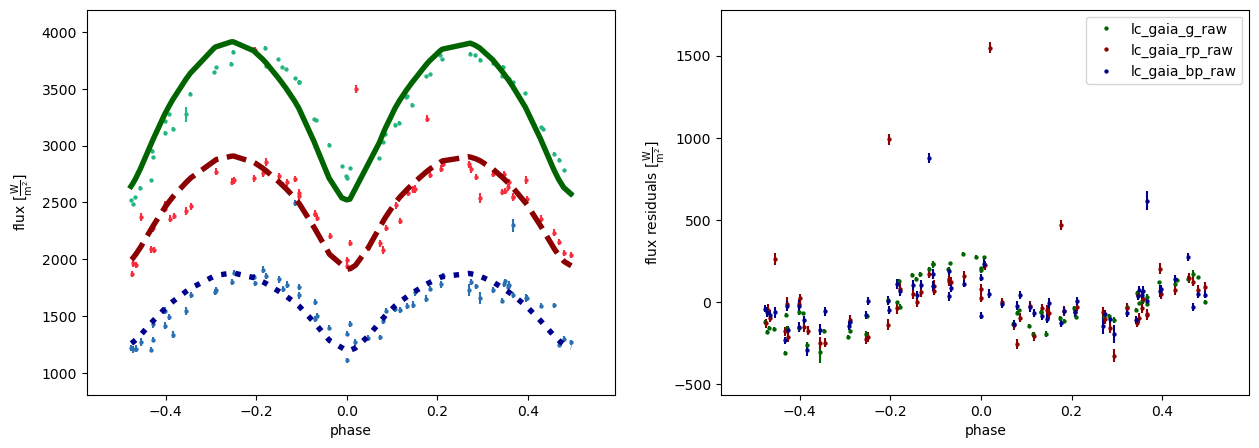

In [19]:
chosenSolution = 'ebai_knn_gaia_raw_solution'
chosenModel = 'ebai_knn_gaia_raw_model'

# raw datasets
_ = gen_utils.plotModelResidualsFigsize(b, (15, 5), datasetGroups=[['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets], model=chosenModel, model_kwargs={"legend": False})

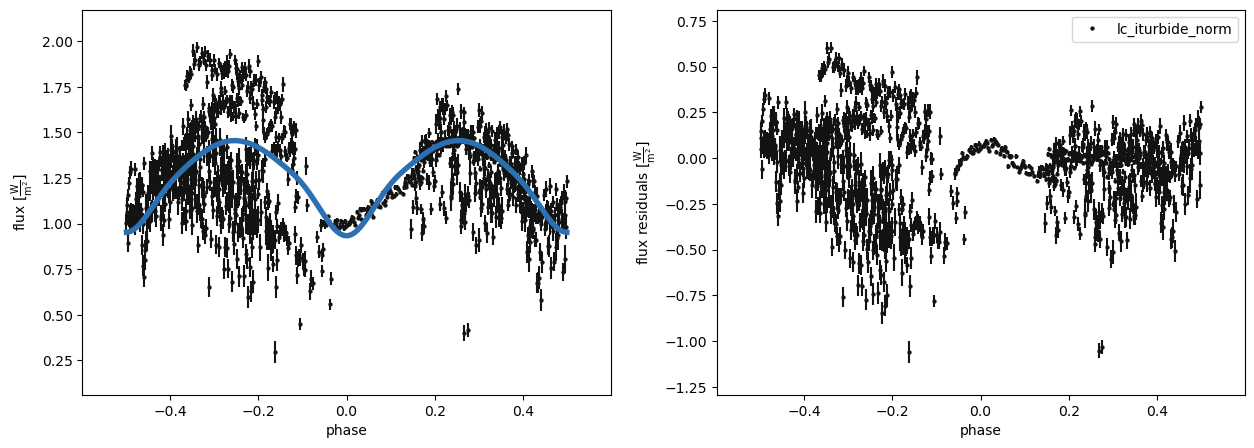

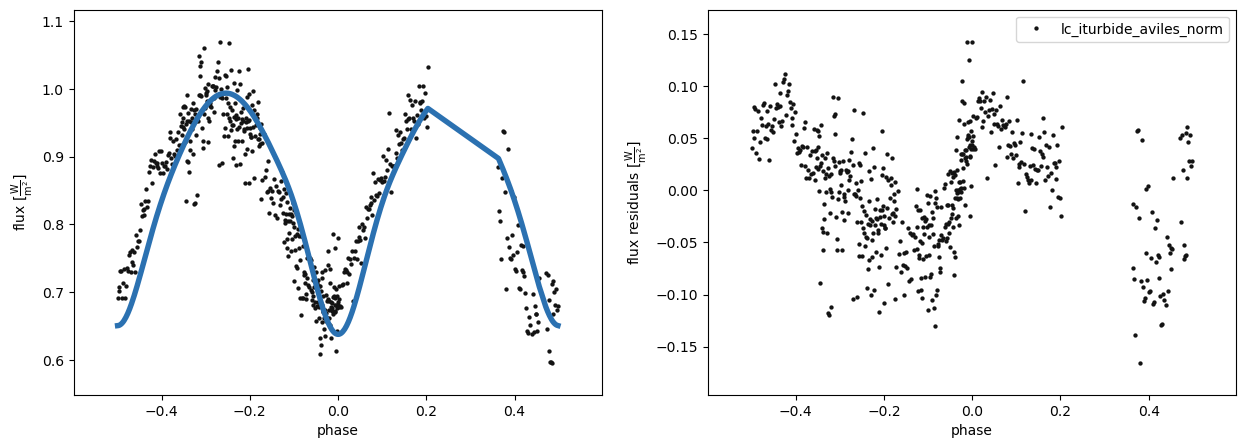

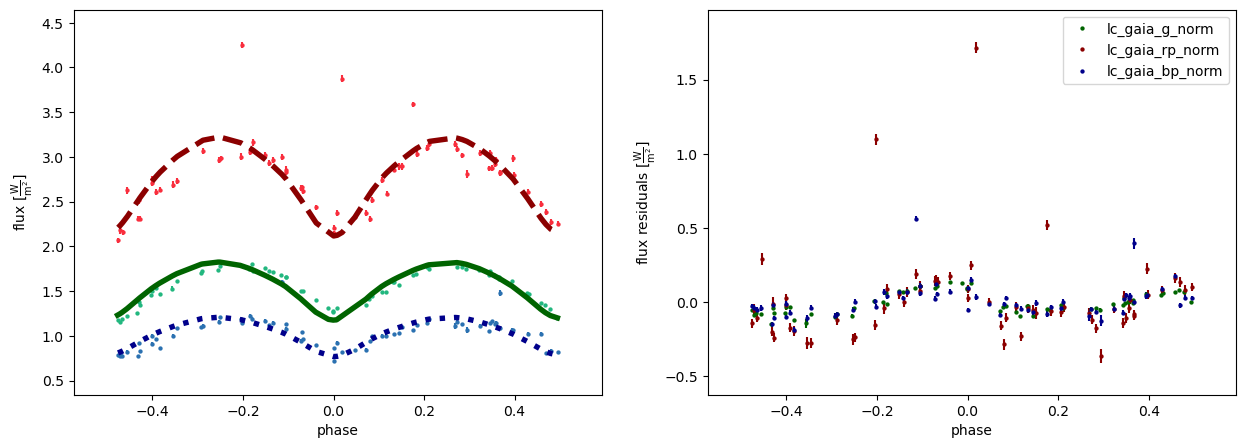

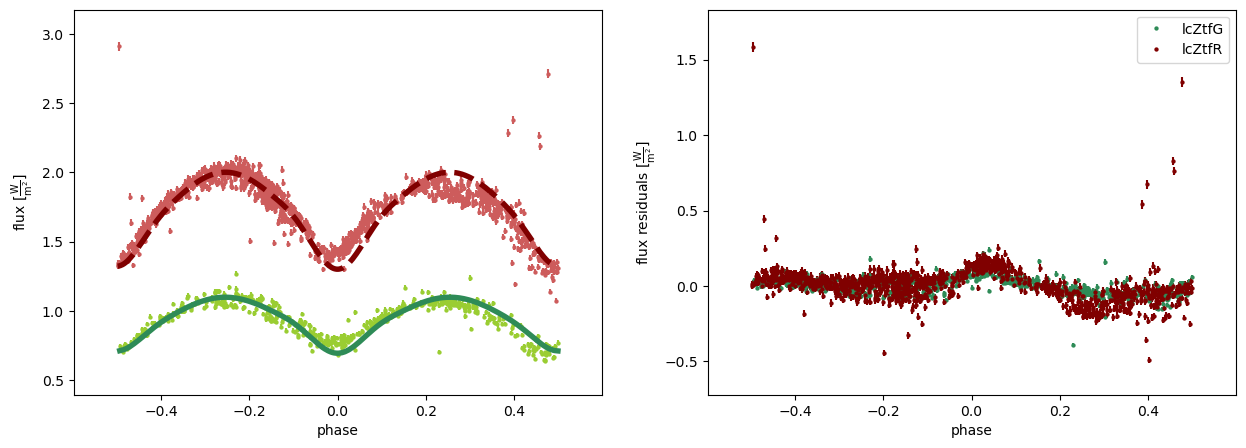

In [21]:
# norm datasets
_ = gen_utils.plotModelResidualsFigsize(b, (15, 5), datasetGroups=[['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets], model=chosenModel, model_kwargs={"legend": False})

In [36]:
# b.adopt_solution('ebai_knn_raw_solution')
b.adopt_solution(chosenSolution)

<ParameterSet: 44 parameters | contexts: dataset, component>

## Save estimator bundle

In [38]:
# gen_utils.saveBundle(b, "ebai-estimates")
# gen_utils.saveBundle(b, "ebai-estimates", "comp-LID3")
# gen_utils.saveBundle(b, "ebai-solver-runs-no-estimates")
gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="aviles-iturbide-gaia-ztf-relative_norm")

'bundle-saves/aviles-iturbide-gaia-ztf-relative_norm/ebai-estimates'

## Trimming Bundle
Dropping unused datasets, as well as cleaning up models that won't be used in future steps

In [39]:
# removing unused models (all of them until now)
b.remove_model(b.models)

<ParameterSet: 1005 parameters | contexts: figure, model>

In [40]:
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed')
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed', "comp-LID3")
gen_utils.saveBundle(b, bundleName="ebai-estimates-trimmed", subfolder="aviles-iturbide-gaia-ztf-ltt-relative_norm")

'bundle-saves/aviles-iturbide-gaia-ztf-ltt-relative_norm/ebai-estimates-trimmed'